In [1]:
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
import networkx as nx
import pandana
import keplergl
import IPython
import base64
from shapely import Point
import geopandas as gpd
import warnings
import folium
import mapclassify
from scipy.stats import kendalltau, pearsonr, spearmanr, linregress, stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, kstest, norm
from shapely.geometry import Polygon

In [2]:
# Notebook themes
#!jt -l

In [3]:
# Notebook themes
#!jt -t chesterish
#!jt -t onedork -fs 115 -nfs 125 -tfs 115 -dfs 115 -ofs 115 -cursc r -cellw 80% -lineh 115 -altmd  -kl -T -N
#!jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T

#### Importing the network

In [4]:
# Define the bounding box coordinates (south, north, west, east)
bbox = (45.419281, 45.449945, 12.298992, 12.368158)
# Create a graph from the bounding box using the bbox parameter
G = ox.graph_from_bbox(north=bbox[1], south=bbox[0], east=bbox[3], west=bbox[2], network_type='walk', simplify=True)

C:\Users\mario\AppData\Local\Temp\ipykernel_11488\3123503170.py:4: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north=bbox[1], south=bbox[0], east=bbox[3], west=bbox[2], network_type='walk', simplify=True)


In [5]:
# Get the geometry of the city polygon
city_total_polygon = ox.geocode_to_gdf("Venezia")['geometry'].iloc[0]

# Create a polygon from the bounding box
min_lat, max_lat, min_lon, max_lon = bbox
sub_polygon_coords = [
    (min_lon, min_lat),
    (min_lon, max_lat),
    (max_lon, max_lat),
    (max_lon, min_lat),
    (min_lon, min_lat)
]
sub_polygon = Polygon(sub_polygon_coords)

# Ensure the sub-polygon is within the city polygon
if sub_polygon.within(city_total_polygon):
    print("Sub-polygon is within the city polygon.")
else:
    print("Sub-polygon is not within the city polygon.")

# Create GeoDataFrames for plotting
city_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[city_total_polygon])
sub_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[sub_polygon])
city_polygon = sub_gdf['geometry'].iloc[0]

Sub-polygon is within the city polygon.


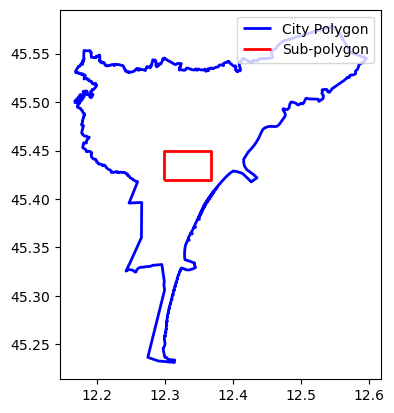

In [6]:
# Plot the city polygon and the sub-polygon
fig, ax = plt.subplots()
city_gdf.boundary.plot(ax=ax, edgecolor='blue', linewidth=2, label='City Polygon')
sub_gdf.boundary.plot(ax=ax, edgecolor='red', linewidth=2, label='Sub-polygon')
plt.legend()
plt.show()

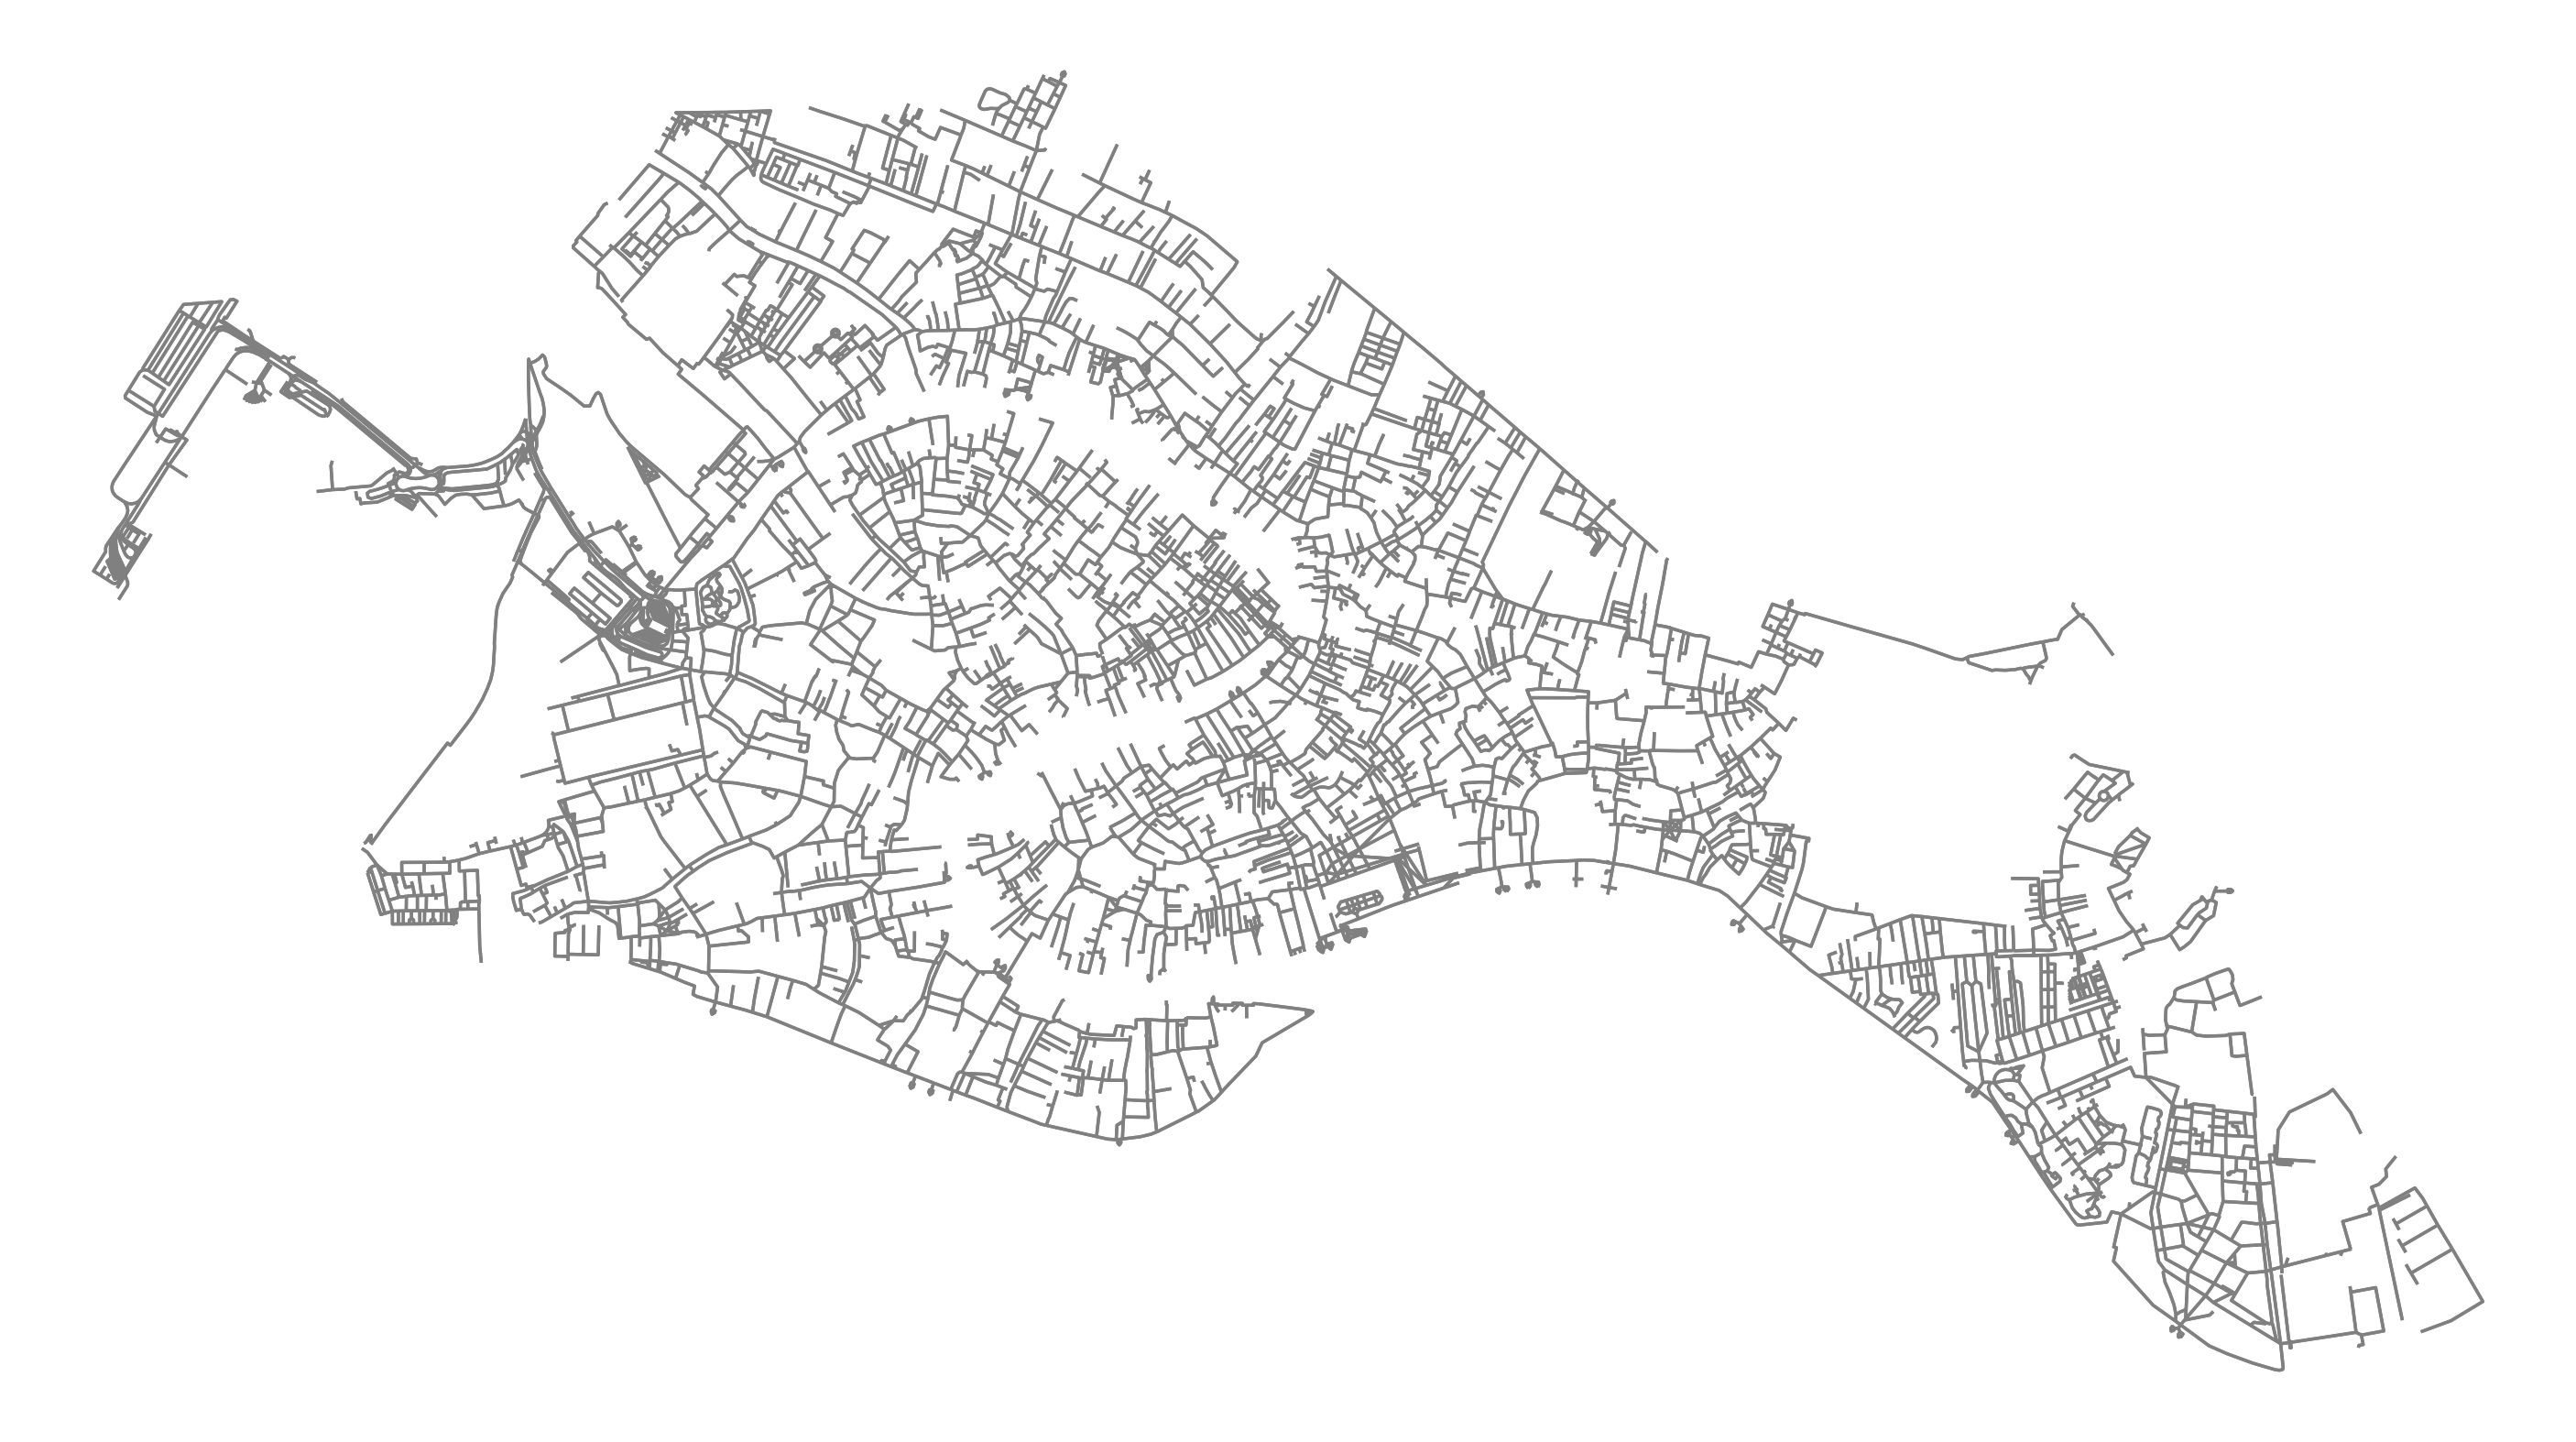

In [7]:
mpl.rcParams['figure.dpi'] = 500
#fig, ax = ox.plot_graph(ox.project_graph(G), node_color='#4CFFD6', node_size=0.5,
#                       edge_color='#4CFFD6', edge_linewidth=0.1, 
#                       figsize=(7, 7))

fig, ax = ox.plot_graph(ox.project_graph(G), 
                       figsize=(7, 7), node_size = 0, bgcolor="white", node_color = "black", 
                       edge_color='gray', edge_linewidth=0.5)


In [8]:
nodes, edges = ox.graph_to_gdfs(G, nodes = True, edges= True)

In [9]:
nodes

y          x  street_count highway  \
osmid                                                     
27178184     45.438197  12.335686             4     NaN   
27178422     45.432325  12.337206             4     NaN   
27178423     45.432482  12.337658             3     NaN   
27178433     45.429240  12.327350             3     NaN   
27223839     45.434570  12.350321             3     NaN   
...                ...        ...           ...     ...   
11947815744  45.432510  12.314047             3     NaN   
11947815745  45.432382  12.314418             3     NaN   
11947815746  45.432513  12.314108             3     NaN   
11947815747  45.432371  12.314121             3     NaN   
11947815750  45.432363  12.313916             3     NaN   

                              geometry  
osmid                                   
27178184     POINT (12.33569 45.43820)  
27178422     POINT (12.33721 45.43233)  
27178423     POINT (12.33766 45.43248)  
27178433     POINT (12.32735 45.42924)  
27223839     POINT (12.35032 45.43457)  
...                                ...  
11947815744  POINT (12.31405 45.43251)  
11947815745  POINT (12.31442 45.43238)  
11947815746  POINT (12.31411 45.43251)  
11947815747  POINT (12.31412 45.43237)  
11947815750  POINT (12.31392 45.43236)  

[5520 rows x 5 columns]

In [10]:
edges

osmid bridge             name  \
u           v           key                                                   
27178184    764403528   0                 166489461    yes  Ponte di Rialto   
            1675825096  0                 166489461    yes  Ponte di Rialto   
            8670969688  0                 450089474    yes  Ponte di Rialto   
            5395065019  0    [450089441, 450089490]    yes  Ponte di Rialto   
27178422    223527689   0                  23243893    NaN              NaN   
...                                             ...    ...              ...   
11947815747 11947815746 0                1288366656    NaN              NaN   
            11947815745 0                1288366655    NaN              NaN   
11947815750 11947815747 0                1288366655    NaN              NaN   
            8247397793  0                1288366655    NaN              NaN   
            11947815744 0                1288366657    NaN              NaN   

                                      highway  oneway reversed  length width  \
u           v           key                                                    
27178184    764403528   0             footway   False    False   9.935   NaN   
            1675825096  0             footway   False     True   5.120   NaN   
            8670969688  0               steps   False    False   9.212     7   
            5395065019  0    [steps, footway]   False     True  24.986     7   
27178422    223527689   0          pedestrian   False     True   7.084   NaN   
...                                       ...     ...      ...     ...   ...   
11947815747 11947815746 0          pedestrian   False     True  15.842   NaN   
            11947815745 0          pedestrian   False    False  23.209   NaN   
11947815750 11947815747 0          pedestrian   False    False  15.988   NaN   
            8247397793  0          pedestrian   False     True   7.004   NaN   
            11947815744 0          pedestrian   False     True  24.844   NaN   

                                                                      geometry  \
u           v           key                                                      
27178184    764403528   0    LINESTRING (12.33569 45.43820, 12.33561 45.43813)   
            1675825096  0    LINESTRING (12.33569 45.43820, 12.33573 45.43823)   
            8670969688  0    LINESTRING (12.33569 45.43820, 12.33560 45.43825)   
            5395065019  0    LINESTRING (12.33569 45.43820, 12.33589 45.438...   
27178422    223527689   0    LINESTRING (12.33721 45.43233, 12.33729 45.43235)   
...                                                                        ...   
11947815747 11947815746 0    LINESTRING (12.31412 45.43237, 12.31411 45.43251)   
            11947815745 0    LINESTRING (12.31412 45.43237, 12.31431 45.432...   
11947815750 11947815747 0    LINESTRING (12.31392 45.43236, 12.31412 45.43237)   
            8247397793  0    LINESTRING (12.31392 45.43236, 12.31384 45.432...   
            11947815744 0    LINESTRING (12.31392 45.43236, 12.31391 45.432...   

                            tunnel lanes maxspeed est_width access area  \
u           v           key                                               
27178184    764403528   0      NaN   NaN      NaN       NaN    NaN  NaN   
            1675825096  0      NaN   NaN      NaN       NaN    NaN  NaN   
            8670969688  0      NaN   NaN      NaN       NaN    NaN  NaN   
            5395065019  0      NaN   NaN      NaN       NaN    NaN  NaN   
27178422    223527689   0      NaN   NaN      NaN       NaN    NaN  NaN   
...                            ...   ...      ...       ...    ...  ...   
11947815747 11947815746 0      NaN   NaN      NaN       NaN    NaN  NaN   
            11947815745 0      NaN   NaN      NaN       NaN    NaN  NaN   
11947815750 11947815747 0      NaN   NaN      NaN       NaN    NaN  NaN   
            8247397793  0      NaN   NaN      NaN       NaN    NaN  NaN   
          

##### Creating Pandana Graph for shortest path calculation

In [11]:
# FOR PANDANA
edges_pdna = edges.droplevel(level=2)
edges_pdna["from"] = edges_pdna.index.get_level_values("u")
edges_pdna["to"] = edges_pdna.index.get_level_values("v")
edges_pdna = edges_pdna.drop(['osmid', 'highway', "oneway", "reversed",
                "lanes", "name", "geometry", "maxspeed",
                "access", "junction", "width", "bridge",
                "tunnel", "service", "ref", "est_width", 
                "area"], axis=1)
edges_pdna.insert(2, "length", edges_pdna.pop("length"))
edges_pdna

from           to  length
u           v                                            
27178184    764403528       27178184    764403528   9.935
            1675825096      27178184   1675825096   5.120
            8670969688      27178184   8670969688   9.212
            5395065019      27178184   5395065019  24.986
27178422    223527689       27178422    223527689   7.084
...                              ...          ...     ...
11947815747 11947815746  11947815747  11947815746  15.842
            11947815745  11947815747  11947815745  23.209
11947815750 11947815747  11947815750  11947815747  15.988
            8247397793   11947815750   8247397793   7.004
            11947815744  11947815750  11947815744  24.844

[14220 rows x 3 columns]

In [12]:
nodes_pdna = nodes[["x", "y"]]

In [13]:
G_pdna = pandana.Network(nodes_pdna['x'], nodes_pdna['y'], 
                          edges_pdna['from'], edges_pdna['to'], 
                          edges_pdna[['length']], twoway = True)

#### Defining X minutes city

In [14]:
X_minutes = 15

#### Defining hotels (source nodes)

In [15]:
# Importing the complete hotel dataset
hotel_col_names = ["gcode_H", "dcode_H", "name_H", "score_H", "review_count_H", 
                  "x_H", "y_H", "istat_pro_com_H", "municipality_H", "hotel_class", 
                  "type_H", "price_5_6_august", "price_range_min", "price_range_max", 
                  "avg_price", "n_rooms", "location_score"] 
hotels_total = pd.read_excel("hotel_dataset_Venezia.xlsx", sheet_name = "hotel_dataset_cleaned_filtered", 
                            names = hotel_col_names)

hotels_total["hotel_class"] = pd.to_numeric(hotels_total["hotel_class"], errors='coerce')

print("Total number of accomodations for all cities in dataset: ", len(hotels_total))
hotels_total.head(3)

Total number of accomodations for all cities in dataset:  552


gcode_H  dcode_H                         name_H  score_H  review_count_H  \
0  g187870  d241741  Hotel Ala-Palazzo Maurogonato      4.5            3935   
1  g187870  d455692                 Ca' del Nobile      4.5             850   
2  g194812  d653718      CÃ  Nova Ristorante Hotel      4.5             161   

         x_H        y_H  istat_pro_com_H municipality_H  hotel_class type_H  \
0  12.332745  45.432311            27042        Venezia          3.0  Hotel   
1  12.336916  45.435246            27042        Venezia          3.0  Hotel   
2  12.225619  45.466509            27042        Venezia          3.0  Hotel   

   price_5_6_august  price_range_min  price_range_max  avg_price  n_rooms  \
0             174.0            180.0            295.0      237.5     80.0   
1               NaN            178.0            276.0      227.0      6.0   
2             146.0             90.0            144.0      117.0      7.0   

   location_score  
0             4.8  
1             4.8  
2             3.6

In [16]:
# Filtering hotels by municipality, type, and presence inside bbox
hotels_df = hotels_total.copy()
print("Total number of accomodation in city: ", len(hotels_df.loc[hotels_df.municipality_H == "Venezia"]))

hotels_df['in_bbox'] = hotels_df.apply(lambda x: city_polygon.contains(Point(x.x_H, x.y_H)), axis=1)

hotels_df = hotels_df.loc[(hotels_df.municipality_H == "Venezia") & 
                          (hotels_df.type_H == "Hotel") & 
                         (hotels_df.in_bbox == True)].reset_index(drop=True)
hotels_df.drop("in_bbox", axis=1, inplace=True)
print("Number of hotels: ", len(hotels_df))
hotels_df.head(3)

Total number of accomodation in city:  552
Number of hotels:  312


gcode_H  dcode_H                         name_H  score_H  review_count_H  \
0  g187870  d241741  Hotel Ala-Palazzo Maurogonato      4.5            3935   
1  g187870  d455692                 Ca' del Nobile      4.5             850   
2  g187870  d202733                 Hotel Bisanzio      4.5            1056   

         x_H        y_H  istat_pro_com_H municipality_H  hotel_class type_H  \
0  12.332745  45.432311            27042        Venezia          3.0  Hotel   
1  12.336916  45.435246            27042        Venezia          3.0  Hotel   
2  12.345194  45.434754            27042        Venezia          4.0  Hotel   

   price_5_6_august  price_range_min  price_range_max  avg_price  n_rooms  \
0             174.0            180.0            295.0      237.5     80.0   
1               NaN            178.0            276.0      227.0      6.0   
2             192.0            213.0            415.0      314.0     43.0   

   location_score  
0             4.8  
1             4.8  
2             4.8

In [17]:
# Getting the nearest node ids to each hotel

id_nearest_node_H, dist_H = ox.distance.nearest_nodes(G, hotels_df['x_H'], 
                                              hotels_df['y_H'], 
                                              return_dist=True)

print("Successful mapping: ", len(hotels_df) == len(id_nearest_node_H))


hotels_df.insert(7, "id_nearest_node_H", id_nearest_node_H)
hotels_df.insert(8, "x_nearest_node_H", 
                 np.float64(nodes.x[id_nearest_node_H]))
hotels_df.insert(9, "y_nearest_node_H", 
                 np.float64(nodes.y[id_nearest_node_H]))

hotels_df.head(3)

Successful mapping:  True


gcode_H  dcode_H                         name_H  score_H  review_count_H  \
0  g187870  d241741  Hotel Ala-Palazzo Maurogonato      4.5            3935   
1  g187870  d455692                 Ca' del Nobile      4.5             850   
2  g187870  d202733                 Hotel Bisanzio      4.5            1056   

         x_H        y_H  id_nearest_node_H  x_nearest_node_H  \
0  12.332745  45.432311         4634918943         12.332966   
1  12.336916  45.435246         1919932131         12.336884   
2  12.345194  45.434754           31061014         12.345176   

   y_nearest_node_H  istat_pro_com_H municipality_H  hotel_class type_H  \
0         45.432374            27042        Venezia          3.0  Hotel   
1         45.435181            27042        Venezia          3.0  Hotel   
2         45.434717            27042        Venezia          4.0  Hotel   

   price_5_6_august  price_range_min  price_range_max  avg_price  n_rooms  \
0             174.0            180.0            295.0      237.5     80.0   
1               NaN            178.0            276.0      227.0      6.0   
2             192.0            213.0            415.0      314.0     43.0   

   location_score  
0             4.8  
1             4.8  
2             4.8

Text(0, 0.5, 'review score')

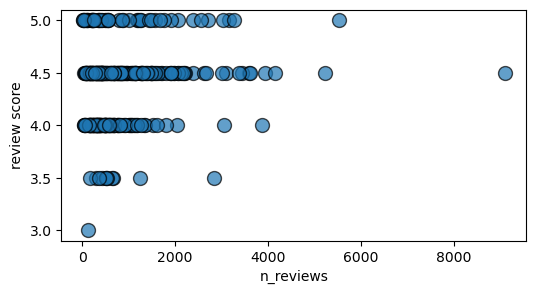

In [18]:
# Distribution of reviews as a function of number of reviews
# for the hotels
mpl.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(hotels_df["review_count_H"], hotels_df["score_H"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

In [19]:
# Calculating Bayesian Average
#m = np.mean(hotels_df.score_H[hotels_df["score_H"] > 0])
#C = 250
#hotels_df["Bayesian_avg_H"] = ((hotels_df.score_H * hotels_df.review_count_H) 
#                                  + (C * m)) / (C + hotels_df.review_count_H)

S = np.mean(hotels_df.score_H[hotels_df["score_H"] > 0])
m_avg = np.mean(hotels_df.review_count_H[hotels_df["score_H"] > 0])

hotels_df["Bayesian_avg_H"] = (hotels_df.review_count_H/(hotels_df.review_count_H + m_avg)) * hotels_df.score_H +\
                                (m_avg/(hotels_df.review_count_H + m_avg)) * S
hotels_df = hotels_df[(hotels_df.score_H > 0) & (hotels_df.review_count_H > 0)]
print("Number of accommodations: ", len(hotels_df))
hotels_df.head(3)

Number of accommodations:  312


gcode_H  dcode_H                         name_H  score_H  review_count_H  \
0  g187870  d241741  Hotel Ala-Palazzo Maurogonato      4.5            3935   
1  g187870  d455692                 Ca' del Nobile      4.5             850   
2  g187870  d202733                 Hotel Bisanzio      4.5            1056   

         x_H        y_H  id_nearest_node_H  x_nearest_node_H  \
0  12.332745  45.432311         4634918943         12.332966   
1  12.336916  45.435246         1919932131         12.336884   
2  12.345194  45.434754           31061014         12.345176   

   y_nearest_node_H  ...  municipality_H hotel_class  type_H price_5_6_august  \
0         45.432374  ...         Venezia         3.0   Hotel            174.0   
1         45.435181  ...         Venezia         3.0   Hotel              NaN   
2         45.434717  ...         Venezia         4.0   Hotel            192.0   

   price_range_min  price_range_max  avg_price  n_rooms  location_score  \
0            180.0            295.0      237.5     80.0             4.8   
1            178.0            276.0      227.0      6.0             4.8   
2            213.0            415.0      314.0     43.0             4.8   

   Bayesian_avg_H  
0        4.477033  
1        4.436543  
2        4.443227  

[3 rows x 21 columns]

<Axes: xlabel='Hotel class', ylabel='Count'>

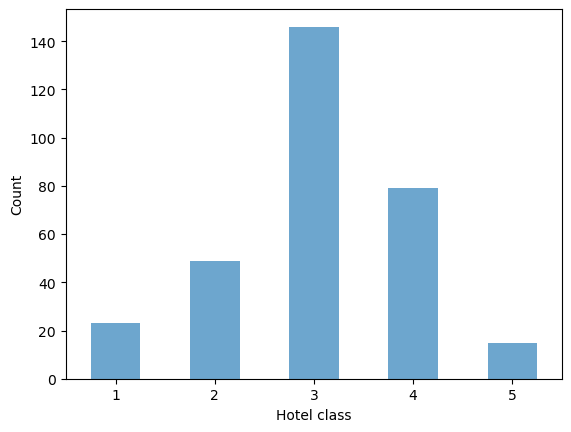

In [20]:
pd.DataFrame(hotels_df.hotel_class.sort_values().astype(int).value_counts(sort=False)).plot.bar(alpha=0.65, xlabel="Hotel class", ylabel="Count", rot=0, legend=False)

#### Defining attractions (destination nodes)

In [21]:
# Importing the complete attractions dataset
attractions_col_names = ["gcode_A", "dcode_A", "name_A", "score_A", "review_count_A", 
                         "x_A", "y_A", "istat_pro_com_A", "municipality_A"] 

attractions_total = pd.read_excel("attraction_dataset.xlsx", sheet_name = "attraction_dataset", 
                                  names = attractions_col_names)

attractions_total.head(3)

gcode_A   dcode_A                    name_A  score_A  review_count_A  \
0  g187785  d2161503        Galleria Borbonica      5.0           10365   
1  g187867   d269082  Cappella degli Scrovegni      5.0            7170   
2  g187867  d8660480               Villa Molin      5.0              35   

         x_A        y_A  istat_pro_com_A municipality_A  
0  14.246260  40.835520            63049         Napoli  
1  11.879536  45.411818            28060         Padova  
2  11.840058  45.362549            28060         Padova

In [22]:
# Filtering attractions by municipality and presence inside bbox
attractions_df = attractions_total.copy()
attractions_df['in_bbox'] = attractions_df.apply(lambda x: city_polygon.contains(Point(x.x_A, x.y_A)), axis=1)
attractions_df = attractions_df.loc[(attractions_df.municipality_A == "Venezia") &
                                   (attractions_df.in_bbox == True)].reset_index(drop=True)
attractions_df.drop("in_bbox", axis=1, inplace=True)
print("Number of attractions: ", len(attractions_df))
attractions_df.head(3)

Number of attractions:  717


gcode_A    dcode_A                                   name_A  score_A  \
0  g187870   d8571065                Centro Storico di Venezia      5.0   
1  g187870   d3981594                  Gioielleria Eredi Jovon      5.0   
2  g187870  d19981154  Creature di Gomma - Venice Vintage Toys      5.0   

   review_count_A        x_A        y_A  istat_pro_com_A municipality_A  
0            2218  12.338472  45.434167            27042        Venezia  
1             476  12.336044  45.437952            27042        Venezia  
2             195  12.327071  45.438269            27042        Venezia

Text(0, 0.5, 'review score')

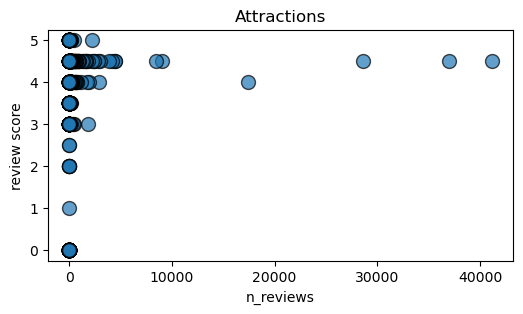

In [23]:
# Distribution of reviews as a function of number of reviews
# for the attractions
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(attractions_df["review_count_A"], attractions_df["score_A"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_title("Attractions")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

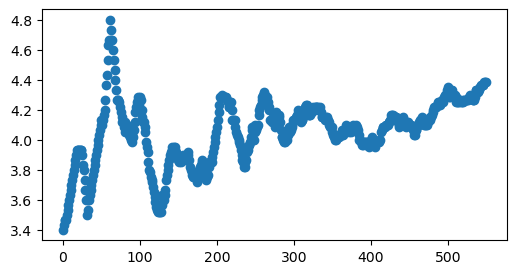

In [24]:
window = 30
j = window - 1
moving_avg = []
df_score = attractions_df.sort_values('review_count_A', ascending = True)
df_score = df_score[df_score["review_count_A"] > 0]
idx = range(0, len(df_score))
for i in idx:
    moving_avg.append(np.mean(df_score.score_A[i:window]))
    window += 1
    if window > len(idx):
        break

fig, ax = plt.subplots(figsize = (6, 3))
#ax.set_xscale("log")
ax.scatter(idx[:-j], moving_avg)    
#ax.set(ylim=(0, 0.000025))

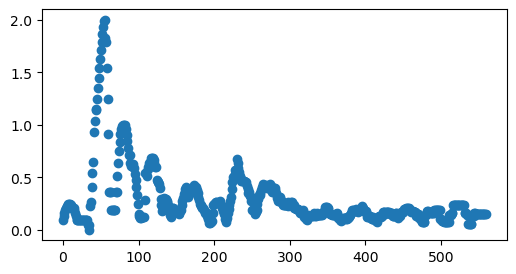

In [25]:
window = 20
j = window - 1
moving_var = []
df_score = attractions_df.sort_values('review_count_A', ascending = True)
df_score = df_score[df_score["review_count_A"] > 0]
idx = range(0, len(df_score))
for i in idx:
    moving_var.append(np.var(df_score.score_A[i:window]))
    window += 1
    if window > len(idx):
        break

fig, ax = plt.subplots(figsize = (6, 3))
#ax.set_xscale("log")
ax.scatter(idx[:-j], moving_var)    
#ax.set(ylim=(0, 0.000025))

In [26]:
# Calculating Bayesian Average for attractions
#m = np.mean(attractions_df.score_A[attractions_df["score_A"] > 0])
#C = 100
#attractions_df["Bayesian_avg_A"] = ((attractions_df.score_A * attractions_df.review_count_A) 
#                                  + (C * m)) / (C + attractions_df.review_count_A)

S = np.mean(attractions_df.score_A[attractions_df["score_A"] > 0])
m_avg = np.mean(attractions_df.review_count_A[attractions_df["score_A"] > 0])

attractions_df["Bayesian_avg_A"] = (attractions_df.review_count_A/(attractions_df.review_count_A + m_avg)) * attractions_df.score_A +\
                                (m_avg/(attractions_df.review_count_A + m_avg)) * S
attractions_df = attractions_df[(attractions_df.score_A > 0) & (attractions_df.review_count_A > 0)]
print("Number of attractions: ", len(attractions_df))
attractions_df.head(10)

Number of attractions:  579


gcode_A    dcode_A                                   name_A  score_A  \
0  g187870   d8571065                Centro Storico di Venezia      5.0   
1  g187870   d3981594                  Gioielleria Eredi Jovon      5.0   
2  g187870  d19981154  Creature di Gomma - Venice Vintage Toys      5.0   
3  g187870  d12176901                 Ca' Zenobio degli Armeni      5.0   
4  g187870   d4591081              The Gritti Epicurean School      5.0   
5  g187870   d6614951        Itaca Art Studio di Monica Martin      5.0   
6  g187870   d8807054                      Le Stanze Del Vetro      5.0   
7  g187870  d10547909         Wood Sculptures by Loris Marazzi      5.0   
8  g187870   d4114830                      Contini Art Gallery      5.0   
9  g187870  d13791846                     AntichitÃ  Guarinoni      5.0   

   review_count_A        x_A        y_A  istat_pro_com_A municipality_A  \
0            2218  12.338472  45.434167            27042        Venezia   
1             476  12.336044  45.437952            27042        Venezia   
2             195  12.327071  45.438269            27042        Venezia   
3             152  12.320833  45.433333            27042        Venezia   
4              87  12.333431  45.431736            27042        Venezia   
5              81  12.323620  45.425657            27042        Venezia   
6              47  12.344811  45.429010            27042        Venezia   
7              42  12.331084  45.430261            27042        Venezia   
8              24  12.334174  45.432832            27042        Venezia   
9              17  12.328483  45.436729            27042        Venezia   

   Bayesian_avg_A  
0        4.859084  
1        4.573338  
2        4.365940  
3        4.314985  
4        4.220264  
5        4.210183  
6        4.147743  
7        4.137718  
8        4.099590  
9        4.083835

In [27]:
# Getting the nearest node ids to each attraction

id_nearest_node_A, dist_A = ox.distance.nearest_nodes(G, attractions_df['x_A'], 
                                              attractions_df['y_A'], 
                                              return_dist=True)

print("Successful mapping: ", len(attractions_df) == len(id_nearest_node_A))


attractions_df.insert(7, "id_nearest_node_A", id_nearest_node_A)
attractions_df.insert(8, "x_nearest_node_A", 
                 np.float64(nodes.x[id_nearest_node_A]))
attractions_df.insert(9, "y_nearest_node_A", 
                 np.float64(nodes.y[id_nearest_node_A]))

attractions_df.head(3)

Successful mapping:  True


gcode_A    dcode_A                                   name_A  score_A  \
0  g187870   d8571065                Centro Storico di Venezia      5.0   
1  g187870   d3981594                  Gioielleria Eredi Jovon      5.0   
2  g187870  d19981154  Creature di Gomma - Venice Vintage Toys      5.0   

   review_count_A        x_A        y_A  id_nearest_node_A  x_nearest_node_A  \
0            2218  12.338472  45.434167         5395074392         12.338188   
1             476  12.336044  45.437952         1779327330         12.336175   
2             195  12.327071  45.438269         4847897732         12.326927   

   y_nearest_node_A  istat_pro_com_A municipality_A  Bayesian_avg_A  
0         45.434080            27042        Venezia        4.859084  
1         45.437910            27042        Venezia        4.573338  
2         45.438199            27042        Venezia        4.365940

(Mean, Std):  22.0 54.5


<Axes: >

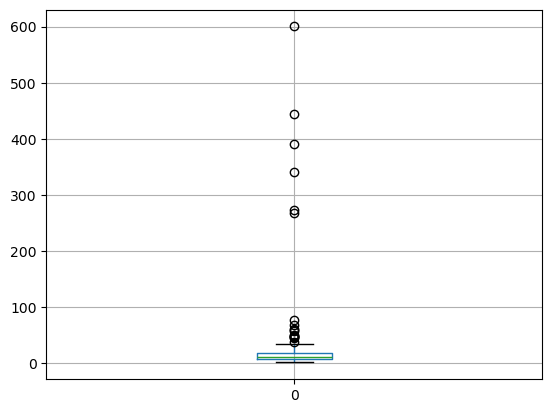

In [28]:
# Distribution of distance
print("(Mean, Std): ", np.around(np.mean(dist_H), decimals=1), np.around(np.std(dist_H), decimals=1))
pd.DataFrame(dist_H).boxplot()

In [29]:
# Filtering top-k attractions based on Bayesian avg.
k = len(attractions_df[attractions_df.Bayesian_avg_A >= 4]) #150 #   len(attractions_df) 
top_k_A_df = attractions_df.sort_values('Bayesian_avg_A', ascending = False)[0:k]
top_k_A_df.reset_index(drop = True, inplace=True)

#fig, ax = plt.subplots(figsize = (8, 6))
#ax.scatter(np.arange(1, 376 , dtype=int), top_k_A_df.Bayesian_avg) 

top_k_A_df[["name_A", "score_A", "review_count_A", "Bayesian_avg_A"]].head(10)

name_A  score_A  review_count_A  \
0                Centro Storico di Venezia      5.0            2218   
1                  Gioielleria Eredi Jovon      5.0             476   
2                             Canal Grande      4.5           41167   
3                         Piazza San Marco      4.5           36935   
4                    Basilica di San Marco      4.5           28570   
5                   Campanile di San Marco      4.5            9064   
6              Collezione Peggy Guggenheim      4.5            8433   
7                               Cannaregio      4.5            4481   
8                         Teatro La Fenice      4.5            4409   
9  Basilica Santa Maria Gloriosa dei Frari      4.5            4170   

   Bayesian_avg_A  
0        4.859084  
1        4.573338  
2        4.495788  
3        4.495311  
4        4.493956  
5        4.481476  
6        4.480150  
7        4.464023  
8        4.463482  
9        4.461565

#### Defining restaurants (destination nodes)

In [30]:
# Importing the complete restaurants dataset
restaurants_col_names = ["gcode_A", "dcode_A", "name_R", "score_R", "review_count_R", 
                         "x_R", "y_R", "istat_pro_com_R", "municipality_R"] 

restaurants_total = pd.read_excel("restaurant_dataset.xlsx", sheet_name = "restaurant_dataset_filtered", 
                                  names = restaurants_col_names)

restaurants_total.head(3)

gcode_A    dcode_A            name_R  score_R  review_count_R        x_R  \
0  g194659  d15656043          Al Gallo      2.0               2  11.794100   
1  g194659   d8752262          Al Viale      4.5              13  11.786176   
2  g194659   d6439949  Alibi CafÃ¨ Club      4.0              31  11.786168   

         y_R  istat_pro_com_R municipality_R  
0  45.375183            28001    Abano Terme  
1  45.356347            28001    Abano Terme  
2  45.356669            28001    Abano Terme

In [31]:
# Filtering restaurants by municipality
restaurants_df = restaurants_total.copy()
restaurants_df['in_bbox'] = restaurants_df.apply(lambda x: city_polygon.contains(Point(x.x_R, x.y_R)), axis=1)
restaurants_df = restaurants_df.loc[(restaurants_df.municipality_R == "Venezia") &
                                   (restaurants_df.in_bbox == True)].reset_index(drop=True)
restaurants_df.drop("in_bbox", axis=1, inplace=True)
restaurants_df.head(3)

gcode_A    dcode_A                           name_R  score_R  \
0  g187870  d16897874                     1000 Gourmet      4.0   
1  g187870  d12342787                  6342 Alla Corte      4.5   
2  g187870  d18378017  8 Millimetri - Cicchetti & Wine      5.0   

   review_count_R        x_R        y_R  istat_pro_com_R municipality_R  
0             423  12.338972  45.435770            27042        Venezia  
1             474  12.341592  45.438570            27042        Venezia  
2               2  12.321647  45.435353            27042        Venezia

Text(0, 0.5, 'review score')

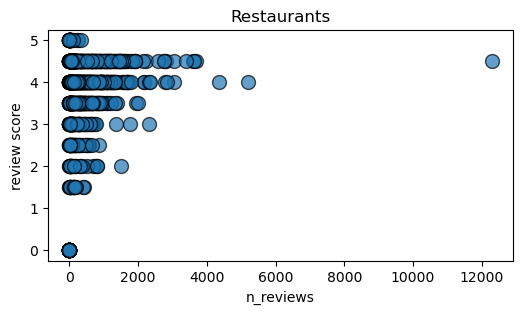

In [32]:
# Distribution of reviews as a function of number of reviews
# for the restaurants
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(restaurants_df["review_count_R"], restaurants_df["score_R"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_title("Restaurants")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

In [33]:
# Calculating Bayesian Average for restaurants
#m = np.mean(restaurants_df.score_R[restaurants_df["score_R"] > 0])
#C = 100
#restaurants_df["Bayesian_avg_R"] = ((restaurants_df.score_R * restaurants_df.review_count_R) 
#                                  + (C * m)) / (C + restaurants_df.review_count_R)

S = np.mean(restaurants_df.score_R[restaurants_df["score_R"] > 0])
m_avg = np.mean(restaurants_df.review_count_R[restaurants_df["score_R"] > 0])

restaurants_df["Bayesian_avg_R"] = (restaurants_df.review_count_R/(restaurants_df.review_count_R + m_avg)) * restaurants_df.score_R +\
                                (m_avg/(restaurants_df.review_count_R + m_avg)) * S
restaurants_df = restaurants_df[(restaurants_df.score_R > 0) & (restaurants_df.review_count_R > 0)]
print("Number of restaurants: ", len(restaurants_df))
restaurants_df.head(3)

Number of restaurants:  942


gcode_A    dcode_A                           name_R  score_R  \
0  g187870  d16897874                     1000 Gourmet      4.0   
1  g187870  d12342787                  6342 Alla Corte      4.5   
2  g187870  d18378017  8 Millimetri - Cicchetti & Wine      5.0   

   review_count_R        x_R        y_R  istat_pro_com_R municipality_R  \
0             423  12.338972  45.435770            27042        Venezia   
1             474  12.341592  45.438570            27042        Venezia   
2               2  12.321647  45.435353            27042        Venezia   

   Bayesian_avg_R  
0        3.925612  
1        4.187280  
2        3.860204

In [34]:
# Getting the nearest node ids to each restaurant

id_nearest_node_R, dist_R = ox.distance.nearest_nodes(G, restaurants_df['x_R'], 
                                              restaurants_df['y_R'], 
                                              return_dist=True)

print("Successful mapping: ", len(restaurants_df) == len(id_nearest_node_R))


restaurants_df.insert(7, "id_nearest_node_R", id_nearest_node_R)
restaurants_df.insert(8, "x_nearest_node_R", 
                 np.float64(nodes.x[id_nearest_node_R]))
restaurants_df.insert(9, "y_nearest_node_R", 
                 np.float64(nodes.y[id_nearest_node_R]))

restaurants_df

Successful mapping:  True


gcode_A    dcode_A                           name_R  score_R  \
0    g187870  d16897874                     1000 Gourmet      4.0   
1    g187870  d12342787                  6342 Alla Corte      4.5   
2    g187870  d18378017  8 Millimetri - Cicchetti & Wine      5.0   
3    g187870  d17862710     8millimetri Cicchetti & Wine      4.5   
4    g187870   d6378872                 A Beccafico Arte      4.5   
..       ...        ...                              ...      ...   
978  g187870  d18195602                  Why&Not osteria      4.5   
979  g187870   d3678475                   Wine Bar Angio      4.0   
980  g187870   d1527672                      Wine Bar HK      3.5   
981  g187870  d12453577                        Zanze XVI      4.5   
982  g187870   d9597062                           Zikiya      3.5   

     review_count_R        x_R        y_R  id_nearest_node_R  \
0               423  12.338972  45.435770         1920010943   
1               474  12.341592  45.438570         4449378094   
2                 2  12.321647  45.435353         8046900486   
3                 7  12.321647  45.435353         8046900486   
4               787  12.332721  45.442319         8603119897   
..              ...        ...        ...                ...   
978              60  12.334087  45.441641          165384690   
979             143  12.350381  45.432264        10570555917   
980             169  12.339930  45.435709         1864853292   
981             517  12.321290  45.438864           60791970   
982             649  12.335944  45.440517          165390289   

     x_nearest_node_R  y_nearest_node_R  istat_pro_com_R municipality_R  \
0           12.338999         45.435707            27042        Venezia   
1           12.341648         45.438467            27042        Venezia   
2           12.321374         45.435518            27042        Venezia   
3           12.321374         45.435518            27042        Venezia   
4           12.332699         45.442213            27042        Venezia   
..                ...               ...              ...            ...   
978         12.334014         45.441669            27042        Venezia   
979         12.349921         45.432389            27042        Venezia   
980         12.339975         45.435641            27042        Venezia   
981         12.321235         45.438868            27042        Venezia   
982         12.335814         45.440459            27042        Venezia   

     Bayesian_avg_R  
0          3.925612  
1          4.187280  
2          3.860204  
3          3.865056  
4          4.266650  
..              ...  
978        3.931532  
979        3.890263  
980        3.757552  
981        4.201240  
982        3.644676  

[942 rows x 13 columns]

In [35]:
# Filtering top-k restaurants based on Bayesian avg.
k = len(restaurants_df[restaurants_df.Bayesian_avg_R >= 4]) #700 #  len(restaurants_df)
top_k_R_df = restaurants_df.sort_values('Bayesian_avg_R', ascending = False)[0:k]
top_k_R_df.reset_index(drop = True, inplace=True)

#fig, ax = plt.subplots(figsize = (8, 6))
#ax.scatter(np.arange(1, 376 , dtype=int), top_k_A_df.Bayesian_avg) 
top_k_R_df[["name_R", "score_R", "review_count_R", "Bayesian_avg_R"]].head(10)

name_R  score_R  review_count_R  \
0               Trattoria Al Gazzettino      4.5           12295   
1                               Da Mamo      4.5            3696   
2                    Ristorante Florida      4.5            3640   
3                     Bistrot de Venise      4.5            3600   
4                 Trattoria Bar Pontini      4.5            3397   
5                      Osteria La Zucca      4.5            3060   
6                     Osteria Al Squero      4.5            2804   
7                Trattoria Alla Ferrata      4.5            2750   
8                               Riviera      4.5            2749   
9  Spaghetteria 6342 A Le Tole Pizzeria      4.5            2569   

   Bayesian_avg_R  
0        4.477414  
1        4.430527  
2        4.429575  
3        4.428879  
4        4.425122  
5        4.417925  
6        4.411461  
7        4.409965  
8        4.409937  
9        4.404560

#### Defining metro stations (destination nodes)

In [36]:
# Data for specified Vaporetto stops with their coordinates
# https://www.venezia-help.com/trasporti/linea-1-vaporetto-actv/
#specified_stops_data = {
#    "name_M": ["Piazzale Roma", "Ferrovia", "Rialto", "San Marco", "San Zaccaria", 
#               "Lido S.M.E.", "Fondamente Nove", "Murano Colonna", "Murano Faro", "Burano", "Giudecca"],
#    "x_M": [12.3194, 12.3211, 12.3358, 12.3390, 12.3432, 
#            12.3694, 12.3522, 12.3539, 12.3525, 12.4164, 12.3251],
#    "y_M": [45.4379, 45.4419, 45.4383, 45.4342, 45.4346, 
#            45.4140, 45.4404, 45.4570, 45.4570, 45.4857, 45.4254]
#}
# https://avm.avmspa.it/sites/default/files/avm/navigazione/Actv_nav_linea_1.pdf
specified_stops_data = {
    "name_M": ["P.le Roma 'F'", "Ferrovia 'b'", "Riva de Biasio", "S. Marcuola-Casino' 'B'", "San Stae",
                "Ca' D'Oro ACTV Fermata", "Rialto Mercato", "Rialto", "S. Silvestro", "S. Angelo",
                "S. Toma' 'A'", "Ca' Rezzonico", "Accademia", "S. Maria del Giglio", "Salute",
                "S. Marco", "S. Marco-San Zaccaria", "Arsenale", "Giardini 'A'", "S. Elena-Stadio Penzo 'C'",
                "Lido S.M.E. 'D'"
                ],
    "x_M": [12.318830, 12.322042, 12.325079, 12.328278, 12.330798, 
              12.333936, 12.335298, 12.335405, 12.333188, 12.330350, 
              12.328128, 12.327122, 12.328523, 12.332637, 12.334374, 
              12.337980, 12.342809, 12.348519, 12.354997, 12.360565, 
              12.367735],
    "y_M": [45.438923, 45.440937, 45.441830, 45.442513, 45.441746, 
             45.440599, 45.439453, 45.437428, 45.436810, 45.435596, 
             45.435249, 45.433285, 45.431736, 45.431452, 45.431171, 
             45.432330, 45.433456, 45.432892, 45.429760, 45.425426, 
             45.417480]
}



# Creating the DataFrame
tram_df = pd.DataFrame(specified_stops_data)

In [37]:
# Reset index
tram_df.reset_index(drop=True, inplace = True)

# Checking if the stations are inside the city
tram_df['in_bbox'] = tram_df.apply(lambda x: city_polygon.contains(Point(x.x_M, x.y_M)), axis=1)
tram_df = tram_df.loc[tram_df.in_bbox == True].reset_index(drop=True)
tram_df.drop("in_bbox", axis=1, inplace=True)

print("Number of Metro/Tram Stations/Stops: ", len(tram_df))
tram_df

Number of Metro/Tram Stations/Stops:  20


name_M        x_M        y_M
0               P.le Roma 'F'  12.318830  45.438923
1                Ferrovia 'b'  12.322042  45.440937
2              Riva de Biasio  12.325079  45.441830
3     S. Marcuola-Casino' 'B'  12.328278  45.442513
4                    San Stae  12.330798  45.441746
5      Ca' D'Oro ACTV Fermata  12.333936  45.440599
6              Rialto Mercato  12.335298  45.439453
7                      Rialto  12.335405  45.437428
8                S. Silvestro  12.333188  45.436810
9                   S. Angelo  12.330350  45.435596
10               S. Toma' 'A'  12.328128  45.435249
11              Ca' Rezzonico  12.327122  45.433285
12                  Accademia  12.328523  45.431736
13        S. Maria del Giglio  12.332637  45.431452
14                     Salute  12.334374  45.431171
15                   S. Marco  12.337980  45.432330
16      S. Marco-San Zaccaria  12.342809  45.433456
17                   Arsenale  12.348519  45.432892
18               Giardini 'A'  12.354997  45.429760
19  S. Elena-Stadio Penzo 'C'  12.360565  45.425426

In [38]:
# Getting the nearest node ids to each tram station

id_nearest_node_M, dist_M = ox.distance.nearest_nodes(G, tram_df['x_M'], 
                                              tram_df['y_M'], 
                                              return_dist=True)

print("Successful mapping: ", len(tram_df) == len(id_nearest_node_M))


tram_df.insert(len(tram_df.columns), "id_nearest_node_M", id_nearest_node_M)
tram_df.insert(len(tram_df.columns), "x_nearest_node_M", 
                 np.float64(nodes.x[id_nearest_node_M]))
tram_df.insert(len(tram_df.columns), "y_nearest_node_M", 
                 np.float64(nodes.y[id_nearest_node_M]))

tram_df

Successful mapping:  True


name_M        x_M        y_M  id_nearest_node_M  \
0               P.le Roma 'F'  12.318830  45.438923         4212293010   
1                Ferrovia 'b'  12.322042  45.440937          565563811   
2              Riva de Biasio  12.325079  45.441830         4730387592   
3     S. Marcuola-Casino' 'B'  12.328278  45.442513         4735865004   
4                    San Stae  12.330798  45.441746         1856788524   
5      Ca' D'Oro ACTV Fermata  12.333936  45.440599         1828524685   
6              Rialto Mercato  12.335298  45.439453         9217895195   
7                      Rialto  12.335405  45.437428         2961006745   
8                S. Silvestro  12.333188  45.436810         3586451556   
9                   S. Angelo  12.330350  45.435596         3586474266   
10               S. Toma' 'A'  12.328128  45.435249         1862236412   
11              Ca' Rezzonico  12.327122  45.433285         5367967919   
12                  Accademia  12.328523  45.431736         3586376605   
13        S. Maria del Giglio  12.332637  45.431452         3586376613   
14                     Salute  12.334374  45.431171        11505541338   
15                   S. Marco  12.337980  45.432330         3586376619   
16      S. Marco-San Zaccaria  12.342809  45.433456         2714417413   
17                   Arsenale  12.348519  45.432892         3586674321   
18               Giardini 'A'  12.354997  45.429760         3586692091   
19  S. Elena-Stadio Penzo 'C'  12.360565  45.425426         3586702556   

    x_nearest_node_M  y_nearest_node_M  
0          12.318843         45.438930  
1          12.322059         45.440906  
2          12.325164         45.441750  
3          12.328299         45.442541  
4          12.330609         45.441514  
5          12.333925         45.440636  
6          12.335183         45.439357  
7          12.335391         45.437441  
8          12.333183         45.436895  
9          12.330417         45.435432  
10         12.328048         45.435310  
11         12.326980         45.433292  
12         12.328493         45.431653  
13         12.332671         45.431543  
14         12.334348         45.431039  
15         12.338010         45.432354  
16         12.342800         45.433438  
17         12.348541         45.432899  
18         12.355115         45.429891  
19         12.360692         45.425460

#### Defining walking speed

In [39]:
# Defining walking speed
speed_ms = 1 # In m/s
speed_mm = speed_ms * 60 # In m/min

#### Creating the combination of each Hotel to each Attraction to calculate Shortest Paths

In [40]:
# Creating keys for cross join
hotels_df['_key'] = 1 
top_k_A_df['_key'] = 1

# Performing the cross join to obtain Hotels-Attractions Data Frame
H_A_df = pd.merge(hotels_df, top_k_A_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
top_k_A_df = top_k_A_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_A_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_A_df["id_nearest_node_H"], H_A_df["id_nearest_node_A"], 
                      imp_name="length")

H_A_df["SP_dist_minutes"] = H_A_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_A_df["GC_dist_meters"] = ox.distance.great_circle(H_A_df.x_nearest_node_H, H_A_df.y_nearest_node_H, 
                                                    H_A_df.x_nearest_node_A, H_A_df.y_nearest_node_A)

# Rearranging DataFrame
H_A_df.insert(0, "name_H", H_A_df.pop("name_H"))
H_A_df.insert(1, "name_A", H_A_df.pop("name_A"))
H_A_df.insert(2, "SP_dist_minutes", H_A_df.pop("SP_dist_minutes"))

In [41]:
H_A_df.sort_values("SP_dist_minutes", ascending = False).head(10)

name_H  \
70004          Hotel Indigo Venice - Sant'Elena   
71132                                Villa Igea   
94256   Veneziacentopercento Rooms & Apartments   
96730                          Casa Sant'Andrea   
59852                        Hotel Ca' Formenta   
96535                          Casa Sant'Andrea   
70138          Hotel Indigo Venice - Sant'Elena   
93910                              Ca' Fontanea   
159334                                 Ca' Doge   
70150          Hotel Indigo Venice - Sant'Elena   

                                           name_A  SP_dist_minutes  gcode_H  \
70004                              Regata Storica       105.472633  g187870   
71132                              Regata Storica        92.975917  g187870   
94256                              Regata Storica        89.656250  g187870   
96730   Scuola Navale Militare Francesco Morosini        86.133117  g187870   
59852                              Regata Storica        85.727567  g187870   
96535                        Chiesa di Sant'Elena        83.670833  g187870   
70138               Church of San Gerardo Sagredo        83.017967  g187870   
93910   Scuola Navale Militare Francesco Morosini        82.920600  g187870   
159334  Scuola Navale Militare Francesco Morosini        82.688883  g187870   
70150                 Calesela Dell'occhio Grosso        82.491633  g187870   

         dcode_H  score_H  review_count_H        x_H        y_H  \
70004   d1086740      4.5            2052  12.362622  45.426483   
71132    d278205      4.5             864  12.355574  45.431591   
94256   d1466198      4.5             333  12.353302  45.433088   
96730    d296854      3.5             660  12.316319  45.438984   
59852    d278290      4.0             773  12.350925  45.431978   
96535    d296854      3.5             660  12.316319  45.438984   
70138   d1086740      4.5            2052  12.362622  45.426483   
93910    d758313      4.0             341  12.318834  45.445845   
159334   d573620      4.0             294  12.317593  45.437600   
70150   d1086740      4.5            2052  12.362622  45.426483   

        id_nearest_node_H  ...        x_A        y_A  id_nearest_node_A  \
70004          2407022947  ...  12.309479  45.447638        10214281224   
71132          5214698846  ...  12.309479  45.447638        10214281224   
94256          1867916159  ...  12.309479  45.447638        10214281224   
96730         10827678158  ...  12.365297  45.426186         9956818363   
59852          9127993394  ...  12.309479  45.447638        10214281224   
96535         10827678158  ...  12.365735  45.427175         9956808790   
70138          2407022947  ...  12.314148  45.426923         3118496943   
93910          1926988632  ...  12.365297  45.426186         9956818363   
159334         9779553482  ...  12.365297  45.426186         9956818363   
70150          2407022947  ...  12.315515  45.440847         8352640265   

       x_nearest_node_A  y_nearest_node_A istat_pro_com_A  municipality_A  \
70004         12.306666         45.443770           27042         Venezia   
71132         12.306666         45.443770           27042         Venezia   
94256         12.306666         45.443770           27042         Venezia   
96730         12.365417         45.426259           27042         Venezia   
59852         12.306666         45.443770           27042         Venezia   
96535         12.365400         45.427083           27042         Venezia   
70138         12.314531         45.431358           27042         Venezia   
93910         12.365417         45.426259           27042         Venezia   
159334        12.365417         45.426259           27042         Venezia   
70150         12.315347         45.440884           27042         Venezia   

        Bayesian_avg_A  SP_dist_meters  GC_dist_meters  
70004         4.109447        6328.358     6495.588110  
71132         4.109447        5578.555     5592.099150  
94256         4.109447    

#### Creating the combination of each Hotel to each Restaurant to calculate Shortest Paths

In [42]:
# Creating keys for cross join
hotels_df['_key'] = 1 
top_k_R_df['_key'] = 1

# Performing the cross join to obtain Hotels-Restaurants Data Frame
H_R_df = pd.merge(hotels_df, top_k_R_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
top_k_R_df = top_k_R_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_R_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_R_df["id_nearest_node_H"], H_R_df["id_nearest_node_R"], 
                      imp_name="length")

H_R_df["SP_dist_minutes"] = H_R_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_R_df["GC_dist_meters"] = ox.distance.great_circle(H_R_df.x_nearest_node_H, H_R_df.y_nearest_node_H, 
                                                    H_R_df.x_nearest_node_R, H_R_df.y_nearest_node_R)

# Rearranging DataFrame
H_R_df.insert(0, "name_H", H_R_df.pop("name_H"))
H_R_df.insert(1, "name_R", H_R_df.pop("name_R"))
H_R_df.insert(2, "SP_dist_minutes", H_R_df.pop("SP_dist_minutes"))

In [43]:
H_R_df.sort_values("SP_dist_minutes", ascending = False).head(3)

name_H            name_R  SP_dist_minutes  \
21948  Hotel Indigo Venice - Sant'Elena   La Tecia Vegana        79.711883   
30231                  Casa Sant'Andrea        Vecia Gina        78.977767   
30223                  Casa Sant'Andrea  Osteria da Pampo        76.816550   

       gcode_H   dcode_H  score_H  review_count_H        x_H        y_H  \
21948  g187870  d1086740      4.5            2052  12.362622  45.426483   
30231  g187870   d296854      3.5             660  12.316319  45.438984   
30223  g187870   d296854      3.5             660  12.316319  45.438984   

       id_nearest_node_H  ...        x_R        y_R  id_nearest_node_R  \
21948         2407022947  ...  12.313599  45.432998         1843720088   
30231        10827678158  ...  12.361812  45.426378         2407022940   
30223        10827678158  ...  12.360879  45.427412         1831507098   

      x_nearest_node_R  y_nearest_node_R istat_pro_com_R  municipality_R  \
21948        12.313405         45.433035           27042         Venezia   
30231        12.361712         45.426341           27042         Venezia   
30223        12.360924         45.427467           27042         Venezia   

       Bayesian_avg_R  SP_dist_meters  GC_dist_meters  
21948        4.136754        4782.713     5516.433431  
30231        4.095384        4738.666     5248.468615  
30223        4.133515        4608.993     5133.068566  

[3 rows x 37 columns]

#### Creating the combination of each Hotel to each Metro/Tram Station/Stop to calculate Shortest Paths

In [44]:
# Creating keys for cross join
hotels_df['_key'] = 1 
tram_df['_key'] = 1

# Performing the cross join to obtain Hotels-Tram Stops Data Frame
H_M_df = pd.merge(hotels_df, tram_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
tram_df = tram_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_M_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_M_df["id_nearest_node_H"], H_M_df["id_nearest_node_M"], 
                      imp_name="length")

H_M_df["SP_dist_minutes"] = H_M_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_M_df["GC_dist_meters"] = ox.distance.great_circle(H_M_df.x_nearest_node_H, H_M_df.y_nearest_node_H, 
                                                    H_M_df.x_nearest_node_M, H_M_df.y_nearest_node_M)

# Rearranging DataFrame
H_M_df.insert(0, "name_H", H_M_df.pop("name_H"))
H_M_df.insert(1, "name_M", H_M_df.pop("name_M"))
H_M_df.insert(2, "SP_dist_minutes", H_M_df.pop("SP_dist_minutes"))

In [45]:
# Keeping the closest tram stop, and adding a binary variable
H_M_df = H_M_df.sort_values("SP_dist_minutes", ascending = True).drop_duplicates(['name_H'])
H_M_df["Metro_Tram_stop"] = [1 if x <= X_minutes else 0 for x in H_M_df['SP_dist_minutes']]
H_M_df.reset_index(drop=True, inplace=True)
H_M_df

name_H                  name_M  \
0                      Hotel Pesaro Palace  Ca' D'Oro ACTV Fermata   
1    NH Collection Venezia Palazzo Barocci               S. Angelo   
2                 Sina Palazzo Sant'Angelo               S. Angelo   
3                  Hotel Al Ponte Mocenigo                San Stae   
4                          Hotel Paganelli   S. Marco-San Zaccaria   
..                                     ...                     ...   
307                  Carnival Palace Hotel            Ferrovia 'b'   
308           Guest House Piccolo Vecellio  Ca' D'Oro ACTV Fermata   
309                           Ca' Fontanea            Ferrovia 'b'   
310                       Alloggi Barbaria   S. Marco-San Zaccaria   
311                          Hotel Tiziano           Ca' Rezzonico   

     SP_dist_minutes   gcode_H   dcode_H  score_H  review_count_H        x_H  \
0           0.000000  g1725258  d2056968      4.0            1342  12.334111   
1           0.000000   g187870   d286614      4.5            1709  12.330340   
2           0.000000   g187870   d256010      4.5            1067  12.330067   
3           0.923883   g187870   d558796      5.0            3170  12.330186   
4           1.062350   g187870   d235889      4.0            1337  12.343076   
..               ...       ...       ...      ...             ...        ...   
307        13.535183   g187870  d2558563      4.5            3431  12.320425   
308        13.874250   g187870   d784711      4.0             136  12.341048   
309        14.104133   g187870   d758313      4.0             341  12.318834   
310        16.092567   g187870   d529166      4.5             390  12.345457   
311        17.920283   g187870   d506155      4.5             778  12.316756   

           y_H  id_nearest_node_H  ...  location_score  Bayesian_avg_H  \
0    45.440649         1828524685  ...             4.8        4.151165   
1    45.435363         3586474266  ...             4.9        4.457437   
2    45.435319         3586474266  ...             4.9        4.443544   
3    45.441033         1856788480  ...             4.7        4.862164   
4    45.434040         1920433119  ...             4.9        4.151503   
..         ...                ...  ...             ...             ...   
307  45.446097         1937756544  ...             4.4        4.474361   
308  45.442772         3586736751  ...             4.4        4.327158   
309  45.445845         1926988632  ...             4.1        4.273109   
310  45.439229         5131599533  ...             4.4        4.413913   
311  45.432933         2656081874  ...             4.1        4.433820   

           x_M        y_M  id_nearest_node_M x_nearest_node_M  \
0    12.333936  45.440599         1828524685        12.333925   
1    12.330350  45.435596         3586474266        12.330417   
2    12.330350  45.435596         3586474266        12.330417   
3    12.330798  45.441746         1856788524        12.330609   
4    12.342809  45.433456         2714417413        12.342800   
..         ...        ...                ...              ...   
307  12.322042  45.440937          565563811        12.322059   
308  12.333936  45.440599         1828524685        12.333925   
309  12.322042  45.440937          565563811        12.322059   
310  12.342809  45.433456         2714417413        12.342800   
311  12.327122  45.433285         5367967919        12.326980   

     y_nearest_node_M  SP_dist_meters  GC_dist_meters  Metro_Tram_stop  
0           45.440636           0.000        0.000000                1  
1           45.435432           0.000        0.000000                1  
2           45.435432           0.000        0.000000                1  
3           45.441514          55.433       63.018807                1  
4           45.433438          63.741       53.072680                1  
..                ...             ...             ...              ...  
307         45.440906         812.111      601.251371

In [46]:
#nx.shortest_path_length(G, 343709332, 332103291, weight = "length") / speed_mm

In [47]:
# Metrics at X minutes distance for attractions

# X minutes level 1
A_lvl1 = pd.DataFrame(H_A_df.name_H[H_A_df["SP_dist_minutes"] <= X_minutes].value_counts())

hotel_name_list_lvl1 = []
hotel_n_reviews_list_lvl1 = []
Bayes_avg_list_H_lvl1 = []

for i in range(0, len(A_lvl1)):
    hotel_name_list_lvl1.append(hotels_df.hotel_class.loc[hotels_df["name_H"] == A_lvl1.index[i]])
    hotel_n_reviews_list_lvl1.append(hotels_df.review_count_H.loc[hotels_df["name_H"] == A_lvl1.index[i]])
    Bayes_avg_list_H_lvl1.append(hotels_df.Bayesian_avg_H.loc[hotels_df["name_H"] == A_lvl1.index[i]])

    
A_lvl1.insert(1, "hotel_class", np.float64(hotel_name_list_lvl1))
A_lvl1.insert(1, "review_count_H", np.float64(hotel_n_reviews_list_lvl1))
A_lvl1.insert(1, "Bayes_avg_H", np.float64(Bayes_avg_list_H_lvl1))
A_lvl1

count  Bayes_avg_H  review_count_H  \
name_H                                                                        
Hotel Rialto                               252     4.085603          3059.0   
Ca' Leon D'Oro                             249     4.409639           329.0   
Residenza Goldoni                          236     4.280571           308.0   
Hotel San Luca                             236     4.247390           470.0   
Hotel Bartolomeo                           235     4.436142           839.0   
...                                        ...          ...             ...   
Veneziacentopercento Rooms & Apartments     38     4.409933           333.0   
Ca' Fontanea                                37     4.273109           341.0   
Hotel Tiziano                               33     4.433820           778.0   
Villa Igea                                  24     4.437047           864.0   
Hotel Indigo Venice - Sant'Elena            11     4.462383          2052.0   

                                         hotel_class  
name_H                                                
Hotel Rialto                                     4.0  
Ca' Leon D'Oro                                   3.0  
Residenza Goldoni                                3.0  
Hotel San Luca                                   3.0  
Hotel Bartolomeo                                 2.0  
...                                              ...  
Veneziacentopercento Rooms & Apartments          2.0  
Ca' Fontanea                                     2.0  
Hotel Tiziano                                    3.0  
Villa Igea                                       3.0  
Hotel Indigo Venice - Sant'Elena                 4.0  

[312 rows x 4 columns]

In [48]:
# Metrics at X minutes distance for restaurants

# X minutes level 1
R_lvl1 = pd.DataFrame(H_R_df.name_H[H_R_df["SP_dist_minutes"] <= X_minutes].value_counts())

hotel_name_list_lvl1 = []
hotel_n_reviews_list_lvl1 = []
Bayes_avg_list_H_lvl1 = []

for i in range(0, len(R_lvl1)):
    hotel_name_list_lvl1.append(hotels_df.hotel_class.loc[hotels_df["name_H"] == R_lvl1.index[i]])
    hotel_n_reviews_list_lvl1.append(hotels_df.review_count_H.loc[hotels_df["name_H"] == R_lvl1.index[i]])
    Bayes_avg_list_H_lvl1.append(hotels_df.Bayesian_avg_H.loc[hotels_df["name_H"] == R_lvl1.index[i]])

    
R_lvl1.insert(1, "hotel_class", np.float64(hotel_name_list_lvl1))
R_lvl1.insert(1, "review_count_H", np.float64(hotel_n_reviews_list_lvl1))
R_lvl1.insert(1, "Bayes_avg_H", np.float64(Bayes_avg_list_H_lvl1))
R_lvl1

count  Bayes_avg_H  review_count_H  \
name_H                                                                 
Ca' Leon D'Oro                       86     4.409639           329.0   
Hotel Bartolomeo                     86     4.436142           839.0   
Hotel Rialto                         85     4.085603          3059.0   
Taverna San Lio                      83     4.314410           178.0   
San Lio Tourist House                83     4.127113           358.0   
...                                 ...          ...             ...   
Ca Santo Spirito                     10     4.395527           163.0   
Generator Venice                      9     4.125848          1793.0   
Belmond Hotel Cipriani                8     4.449316          1291.0   
Villa Igea                            8     4.437047           864.0   
Hotel Indigo Venice - Sant'Elena      3     4.462383          2052.0   

                                  hotel_class  
name_H                                         
Ca' Leon D'Oro                            3.0  
Hotel Bartolomeo                          2.0  
Hotel Rialto                              4.0  
Taverna San Lio                           3.0  
San Lio Tourist House                     3.0  
...                                       ...  
Ca Santo Spirito                          3.0  
Generator Venice                          1.0  
Belmond Hotel Cipriani                    5.0  
Villa Igea                                3.0  
Hotel Indigo Venice - Sant'Elena          4.0  

[312 rows x 4 columns]

# FOR JUPYTER LAB

test_map = keplergl.KeplerGl()

df = hotels_df[["name_H", "x_H", "y_H"]].copy()
df.rename(columns={"name_H": "Hotel name", "x_H": "Longitude", "y_H":"Latitude"}, inplace = True)
df_Count = []
for name in list(df["Hotel name"]):
    if name in A_lvl1.index:
        df_Count.append(A_lvl1.values[A_lvl1.index==name][0][0])
    else:
        df_Count.append(0)
df.insert(len(df.columns), "Count", df_Count)
test_map.add_data(data=df)

#test_map.add_data(data=counts_H)


orig_html = str(test_map._repr_html_(),'utf-8')

better_html = orig_html
b64 = base64.b64encode(better_html.encode('utf-8'))
src = f"data:text/html;base64,{b64.decode('utf-8')}"
base64d_html = f'<iframe src="{src}" style="width:100%; height: 400px">'
IPython.display.HTML(base64d_html)

In [49]:
# KeplerGL config

kepler_config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '2fxa7ht',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels',
      'color': [184, 110, 218],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [184, 110, 218],
        'size': 11,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'csiktu',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_points_TWI',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 8,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [173, 185, 51],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'TWI', 'type': 'real'},
      'colorScale': 'quantize',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'ifo3kcp',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_points_Walkability_num',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 8,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [173, 185, 51],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Walkability_num',
       'type': 'integer'},
      'colorScale': 'quantize',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '3tag46c',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_A_count',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Count_A', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Count_A', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': 'aw0qhcc',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_R_count',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Count_R', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Count_R', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': 'pmgr4v',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_M_binary',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Metro_Tram_stop',
       'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Metro_Tram_stop', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': '76hrvw',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_A_Closeness',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#99FF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Closeness_Centrality_Attractions',
       'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Closeness_Centrality_Attractions',
       'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': 'aqi7i2u',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_R_Closeness',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#99FF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Closeness_Centrality_Restaurants',
       'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Closeness_Centrality_Restaurants',
       'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': 'qy3pmbe',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_class',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#CCFF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [200, 600],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantize',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'd9bu4gf',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_score',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'coverage': 1,
       'sizeRange': [20, 300],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Score_H', 'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Score_H', 'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': '6r22q1w',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_review_count',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'coverage': 1,
       'sizeRange': [20, 300],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Review_count_H',
       'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Review_count_H', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': '2sol0j',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_Bayes_Avg',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 8],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_H',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '6g29u9r',
     'type': 'heatmap',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_heat_map',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'radius': 100},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'weightField': None, 'weightScale': 'linear'}},
    {'id': '2jqr7zb',
     'type': 'point',
     'config': {'dataId': 'Attractions',
      'label': 'Attractions',
      'color': [36, 115, 189],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [72, 43, 189],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [66, 101, 204],
        'size': 10,
        'offset': [0, 0],
        'anchor': 'middle',
        'alignment': 'bottom'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'se4ty0m',
     'type': 'point',
     'config': {'dataId': 'Restaurants',
      'label': 'Restaurants',
      'color': [218, 0, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [240, 237, 234],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'middle',
        'alignment': 'bottom'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'o69bpud',
     'type': 'point',
     'config': {'dataId': 'Metro/Tram',
      'label': 'Metro/Tram Stops',
      'color': [214, 160, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': {'name': 'Tram Stop name', 'type': 'string'},
        'color': [185, 118, 0],
        'size': 10,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'pj7phwm',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'price',
      'color': [34, 63, 154],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#00FF00', '#CCFF00', '#FFCC00', '#FF6600', '#FF0000'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'mxggy1p',
     'type': 'point',
     'config': {'dataId': 'Attractions',
      'label': 'Bayes Attractions',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_A',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '79yotqi',
     'type': 'point',
     'config': {'dataId': 'Restaurants',
      'label': 'Bayes Restaurants',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude',
       'lng': 'Longitude',
       'altitude': 'Bayesian_avg_R'},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_R',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'unnamed': [{'name': 'Hotel name',
        'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None},
       {'name': 'Walkability_num', 'format': None}],
      'Attractions': [{'name': 'Attraction name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}],
      'Restaurants': [{'name': 'Restaurant name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}],
      'Metro/Tram': [{'name': 'Tram Stop name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 45.435451166836046,
   'longitude': 12.340343624665904,
   'pitch': 0,
   'zoom': 13.13831314348632,
   'isSplit': False},
  'mapStyle': {'styleType': 'a0lwzne',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': False,
    'road': True,
    'building': True,
    'water': True,
    'land': True},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {'a0lwzne': {'accessToken': None,
     'custom': True,
     'icon': 'https://api.mapbox.com/styles/v1/mapbox/streets-v12/static/-122.3391,37.7922,9,0,0/400x300?access_token=pk.eyJ1IjoidWNmLW1hcGJveCIsImEiOiJja3RpeXhkaXcxNzJtMnZxbmtkcnJuM3BkIn0.kGmGlkbuWaCBf7_RrZXULg&logo=false&attribution=false',
     'id': 'a0lwzne',
     'label': 'Mapbox Streets',
     'url': 'mapbox://styles/mapbox/streets-v12'}}}}}

In [50]:
# Hotels
df = hotels_df[["name_H", "x_H", "y_H"]].copy()
df.rename(columns={"name_H": "Hotel name", "x_H": "Longitude", "y_H":"Latitude"}, inplace = True)
df_Count_A = []
df_Count_R = []
df_metro_tram_stop = []
df_CC_A = [] # Closeness centrality calculation to each Attraction node (every node)
df_CC_R = [] # Closeness centrality calculation to each Restaurant node (every node)
df_ST_A = [] # Directness calculation to each Attraction node (every node)
df_ST_R = [] # Directness calculation to each Restaurant node (every node)

for name in list(df["Hotel name"]):
    if name in A_lvl1.index:
        df_Count_A.append(A_lvl1.values[A_lvl1.index==name][0][0])
    else:
        df_Count_A.append(0)
    if name in R_lvl1.index:
        df_Count_R.append(R_lvl1.values[R_lvl1.index==name][0][0])
    else:
        df_Count_R.append(0)
    df_metro_tram_stop.append(H_M_df.Metro_Tram_stop[H_M_df.name_H == name].values[0])
    df_CC_A.append(len(top_k_A_df)/np.sum(H_A_df.SP_dist_meters[H_A_df.name_H == name]))
    df_CC_R.append(len(top_k_R_df)/np.sum(H_R_df.SP_dist_meters[H_R_df.name_H == name]))
    df_ST_A.append(len(top_k_A_df)/np.sum(H_A_df.SP_dist_meters[H_A_df.name_H == name]))
    
df.insert(len(df.columns), "Count_A", df_Count_A)
df.insert(len(df.columns), "Count_R", df_Count_R)
df.insert(len(df.columns), "Metro_Tram_stop", df_metro_tram_stop)
df.insert(len(df.columns), "Closeness_Centrality_Attractions", df_CC_A)
df.insert(len(df.columns), "Closeness_Centrality_Restaurants", df_CC_R)
df["Hotel_class"] = hotels_df.hotel_class[hotels_df["name_H"] == df["Hotel name"]]
df["Review_count_H"] = hotels_df.review_count_H[hotels_df["name_H"] == df["Hotel name"]]
df["Score_H"] = hotels_df.score_H[hotels_df["name_H"] == df["Hotel name"]]
df["Bayesian_avg_H"] = hotels_df.Bayesian_avg_H[hotels_df["name_H"] == df["Hotel name"]]
df["avg_price"] = hotels_df.avg_price[hotels_df["name_H"] == df["Hotel name"]]
df["avg_price_log"] = np.log(hotels_df.avg_price[hotels_df["name_H"] == df["Hotel name"]])
df["price_5_6_august"] = hotels_df.price_5_6_august[hotels_df["name_H"] == df["Hotel name"]]
df["price_range_min"] = hotels_df.price_range_min[hotels_df["name_H"] == df["Hotel name"]]
df["price_range_max"] = hotels_df.price_range_max[hotels_df["name_H"] == df["Hotel name"]]
df["location_score"] = hotels_df.location_score[hotels_df["name_H"] == df["Hotel name"]]
df["n_rooms"] = hotels_df.n_rooms[hotels_df["name_H"] == df["Hotel name"]]



# Attractions
df2 = top_k_A_df[["name_A", "x_A", "y_A", "Bayesian_avg_A"]].copy()
df2.rename(columns={"name_A": "Attraction name", "x_A": "Longitude", "y_A":"Latitude"}, inplace = True)

# Restaurants
df3 = top_k_R_df[["name_R", "x_R", "y_R", "Bayesian_avg_R"]].copy()
df3.rename(columns={"name_R": "Restaurant name", "x_R": "Longitude", "y_R":"Latitude"}, inplace = True)

# Metro/Tram
df4 = tram_df[["name_M", "x_M", "y_M"]].copy()
df4.rename(columns={"name_M": "Tram Stop name", "x_M": "Longitude", "y_M":"Latitude"}, inplace = True)

#### Tourism Walkability Index

In [51]:
# Three variables are going to be used for calculating the Tourism Walkability Index:
# Count of Attractions
# Count of Restaurants
# Average of Bayesian Score for Attractions and Restaurants

# Calculating the mean and std of each variable
mean_A = np.mean(df.Count_A)
std_A = np.std(df.Count_A)
mean_R = np.mean(df.Count_R)
std_R = np.std(df.Count_R)
#mean_BA = np.mean(top_k_A_df.Bayesian_avg_A)
#std_BA = np.std(top_k_A_df.Bayesian_avg_A)

mean_BA = np.mean(H_A_df.Bayesian_avg_A[H_A_df["SP_dist_minutes"] <= X_minutes])
std_BA = np.std(H_A_df.Bayesian_avg_A[H_A_df["SP_dist_minutes"] <= X_minutes])
mean_BR = np.mean(H_R_df.Bayesian_avg_R[H_R_df["SP_dist_minutes"] <= X_minutes])
std_BR = np.std(H_R_df.Bayesian_avg_R[H_R_df["SP_dist_minutes"] <= X_minutes])

# Calculating Z-score for each hotel (standardization)
df["Count_A_Z"] = (df.Count_A - mean_A) / std_A
df["Count_R_Z"] = (df.Count_R - mean_R) / std_R
Bayes_mean_A = []
Bayes_mean_R = []
for name in hotels_df.name_H:
    Bayes_aux_A = np.mean(H_A_df.Bayesian_avg_A[(H_A_df["name_H"] ==  name) 
                                                    & (H_A_df["SP_dist_minutes"] <= X_minutes)])
    Bayes_aux_R = np.mean(H_R_df.Bayesian_avg_R[(H_R_df["name_H"] ==  name) 
                                                & (H_R_df["SP_dist_minutes"] <= X_minutes)])
    if np.isnan(Bayes_aux_A):
        Bayes_mean_A.append(0)
    else:
        Bayes_mean_A.append(Bayes_aux_A)
    if np.isnan(Bayes_aux_R):
        Bayes_mean_R.append(0)
    else:
        Bayes_mean_R.append(Bayes_aux_R)
df["Bayes_mean_A"] = Bayes_mean_A
df["Bayes_mean_R"] = Bayes_mean_R

In [52]:
# Defining index using "additive method" (weights can be defined in this step)

check_correlation = 0 # If 1, it looks for the combination that gives the best correlation, if 0, it continues with
# the predefined ones

if check_correlation == 1:
    # Looking for the highest correlation
    # Define the ranges for w1, w2, w3, and w4
    w1_range = np.arange(0, 5.1, 0.2)
    w2_range = np.arange(0, 5.1, 0.2)

    # Initialize variables to store the best correlation and the best weights
    best_corr = -1
    best_weights = (0, 0)

    # Iterate over all combinations of w1, w2, w3, and w4
    jj = 0
    for w1 in w1_range:
        for w2 in w2_range:
            for w3 in w3_range:
                for w4 in w4_range:
                    # Calculate the TWI for the current combination of weights
                    df["TWI"] = (w1 * df["Count_A_Z"] +
                                 w2 * df["Count_R_Z"])
                
                    # Calculate the Spearman correlation
                    corr, _ = pearsonr(df["location_score"], df["TWI"])
                
                    # Update the best correlation and weights if the current correlation is higher
                    if corr > best_corr:
                        best_corr = corr
                        best_weights = (w1, w2)
        jj+=1
        print(f"Iteration {jj}/{len(w1_range)}")
    print(f"Best Spearman correlation: {best_corr}")
    print(f"Best weights: w1={best_weights[0]}, w2={best_weights[1]}")
    df["TWI"] = (best_weights[0] * df["Count_A_Z"] +
                best_weights[1] * df["Count_R_Z"])

else:
    # Output the best correlation and the corresponding weights
    best_weights =  (2, 1) #(1.9, 2.3, 0, 0) # Considering all the attractions and restaurants: w1=0.0, w2=1.0, w3=4.6, w4=0.0 or (0.4, 2.2)
                    # Considering 150 att and 700 rest: (1.6, 1.8, 4.4, 0.0) or (1.9, 2.3)
    df["TWI"] = (best_weights[0] * df["Count_A_Z"] +
                best_weights[1] * df["Count_R_Z"])
    corr, _ = spearmanr(df["location_score"], df["TWI"])
    print(f"Best Spearman correlation: {corr}")
    print(f"Best weights: w1={best_weights[0]}, w2={best_weights[1]}")

# Scaling the index
a = 0 # Min value of the scale
b = 100 # Max value of the scale
df["TWI"] = a + ((df["TWI"] - np.min(df["TWI"])) * (b - a)) / (np.max(df["TWI"]) - np.min(df["TWI"]))

Best Spearman correlation: 0.39299286467718275
Best weights: w1=2, w2=1


Text(0, 0.5, 'TWI')

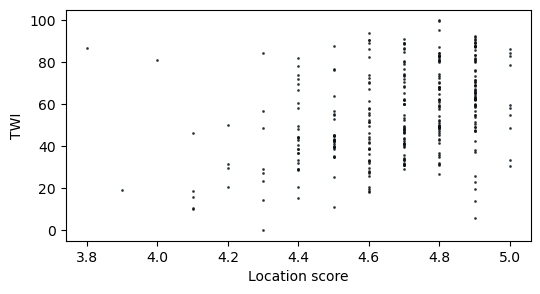

In [53]:
# Distribution of index as a function of location score
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(df["location_score"], df["TWI"], 
           s=1, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_xlabel("Location score")
ax.set_ylabel("TWI")

In [54]:
# Index interval classification
conditions = [
    (df['TWI'] > 20) & (df['TWI'] <= 40),
    (df['TWI'] > 40) & (df['TWI'] <= 60),
    (df['TWI'] > 60) & (df['TWI'] <= 80),
    (df['TWI'] > 80) & (df['TWI'] <= 100)]
choices_quali = ['Basic', 'Average', 'High', 'Excelent']
choices_quant = [2, 3, 4, 5]
df['Walkability'] = np.select(conditions, choices_quali, default='Poor')
df['Walkability_num'] = np.select(conditions, choices_quant, default=1)

df

Hotel name  Longitude   Latitude  Count_A  Count_R  \
0    Hotel Ala-Palazzo Maurogonato  12.332745  45.432311    171.0     38.0   
1                   Ca' del Nobile  12.336916  45.435246    212.0     74.0   
2                   Hotel Bisanzio  12.345194  45.434754    119.0     46.0   
3                Antica Casa Coppo  12.334843  45.434935    202.0     62.0   
4                      Ca dei Polo  12.321638  45.438204    111.0     43.0   
..                             ...        ...        ...      ...      ...   
307               Avogaria 5 rooms  12.321022  45.432114     99.0     40.0   
308                      Hotel Rio  12.341550  45.435179    180.0     64.0   
309            Ca' Dell'Arte Suite  12.339985  45.436447    203.0     75.0   
310           Residence Corte Nova  12.346010  45.437014    108.0     41.0   
311           Hotel Antiche Figure  12.322096  45.440222    106.0     45.0   

     Metro_Tram_stop  Closeness_Centrality_Attractions  \
0                  1                          0.000798   
1                  1                          0.000894   
2                  1                          0.000652   
3                  1                          0.000883   
4                  1                          0.000639   
..               ...                               ...   
307                1                          0.000633   
308                1                          0.000767   
309                1                          0.000830   
310                1                          0.000622   
311                1                          0.000625   

     Closeness_Centrality_Restaurants  Hotel_class  Review_count_H  ...  \
0                            0.000759          3.0            3935  ...   
1                            0.000919          3.0             850  ...   
2                            0.000678          4.0            1056  ...   
3                            0.000880          3.0             294  ...   
4                            0.000676          4.0             788  ...   
..                                ...          ...             ...  ...   
307                          0.000630          3.0             217  ...   
308                          0.000809          2.0             619  ...   
309                          0.000898          3.0              55  ...   
310                          0.000664          1.5             267  ...   
311                          0.000672          3.0            5539  ...   

     price_range_max  location_score  n_rooms  Count_A_Z  Count_R_Z  \
0              295.0             4.8     80.0   0.508512  -0.520929   
1              276.0             4.8      6.0   1.302275   1.316719   
2              415.0             4.8     43.0  -0.498211  -0.112562   
3              274.0             4.5     11.0   1.108674   0.704170   
4              171.0             4.7      6.0  -0.653092  -0.265700   
..               ...             ...      ...        ...        ...   
307            293.0             4.6      5.0  -0.885413  -0.418837   
308            249.0             4.9     17.0   0.682753   0.806261   
309            449.0             4.4      5.0   1.128034   1.367765   
310            315.0             4.6     10.0  -0.711172  -0.367791   
311            407.0             4.8     22.0  -0.749892  -0.163608   

     Bayes_mean_A  Bayes_mean_R        TWI  Walkability  Walkability_num  
0        4.081945      4.243772  59.048924      Average                3  
1        4.080292      4.227999  84.388095     Excelent                5  
2        4.091658      4.246646  47.174658      Average                3  
3        4.077626      4.232789  76.992017         High                4  
4        4.072420      4.199044  43.750171      Average                3  
..            ...           ...        ...          ...              ...  
307      4.082317      4.194504  39.179889        Basic                2  
308      4.086012      4.239448  71.

<Axes: xlabel='Walkability', ylabel='Count'>

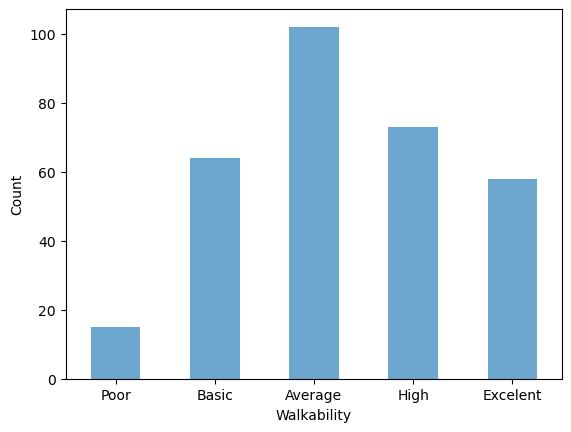

In [55]:
# Walkability index histogram
counts_for_plot = []
walkability_levels = ['Poor', 'Basic', 'Average', 'High', 'Excelent']
for i in walkability_levels:
    if i in df.Walkability.values:
        counts_for_plot.append(len(df[df.Walkability == i]))
    else:
        counts_for_plot.append(0)
pd.DataFrame({"Walkability":walkability_levels, "TWI":counts_for_plot}).plot.bar(x="Walkability", alpha=0.65, xlabel="Walkability", ylabel="Count", rot=0, legend=False)

In [55]:
test_map = keplergl.KeplerGl(height = 800, config=kepler_config)

test_map.add_data(data=df)
test_map.add_data(data=df2, name="Attractions")
test_map.add_data(data=df3, name="Restaurants")
test_map.add_data(data=df4, name="Metro/Tram")
test_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718:

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '2fxa7ht', 'type': …

In [56]:
test_map.config

{'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '2fxa7ht',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels',
      'color': [184, 110, 218],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',

In [57]:
# Saving the map to html
test_map.save_to_html(file_name='kepler_map_Venezia_hotel_15min.html')

Map saved to kepler_map_Venezia_hotel_15min.html!


In [58]:
df["TWI"].to_excel("TWI_hotels_Venezia.xlsx")

#### Price analysis

In [58]:
# Run this ONCE
df2 = df.copy()

In [59]:
df = df2

In [60]:
# Removing price outliers
Q1 = df['avg_price_log'].quantile(0.25)
Q3 = df['avg_price_log'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df = df[(df['avg_price_log'] >= Q1 - 1.5 * IQR) & (df['avg_price_log'] <= Q3 + 1.5 *IQR)]

In [61]:
len(df)

301

In [62]:
df.Hotel_class = df.Hotel_class.astype(int)
df.Hotel_class.value_counts().sort_values()

C:\Users\mario\AppData\Local\Temp\ipykernel_20112\3655989462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Hotel_class = df.Hotel_class.astype(int)


Hotel_class
5      4
1     23
2     49
4     79
3    146
Name: count, dtype: int64

In [63]:
# Creating quantiles (quartiles) for review_count_H and n_rooms
df["n_rooms_quant"] = pd.qcut(df.n_rooms, 4, labels=False)
#df["Review_count_H_quant"] = pd.qcut(df.Review_count_H, 4, labels=False)

C:\Users\mario\AppData\Local\Temp\ipykernel_20112\1898345718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n_rooms_quant"] = pd.qcut(df.n_rooms, 4, labels=False)


In [64]:
# Get dummies
df_dummies = pd.get_dummies(df, columns = ["Hotel_class", "n_rooms_quant", "Walkability_num"], dtype = int)
df_dummies["Hotel_class_12"] = (df_dummies["Hotel_class_1"].apply(bool) | 
                                    df_dummies["Hotel_class_2"].apply(bool)).replace({True: 1, False: 0})
df_dummies["Hotel_class_45"] = (df_dummies["Hotel_class_4"].apply(bool) | 
                                    df_dummies["Hotel_class_5"].apply(bool)).replace({True: 1, False: 0})

C:\Users\mario\AppData\Local\Temp\ipykernel_20112\76144645.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dummies["Hotel_class_2"].apply(bool)).replace({True: 1, False: 0})
C:\Users\mario\AppData\Local\Temp\ipykernel_20112\76144645.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dummies["Hotel_class_5"].apply(bool)).replace({True: 1, False: 0})


In [65]:
# Export the DataFrame to Excel file
#df_dummies.to_excel("Napoli_dataframe_stat_analysis.xlsx")

In [66]:
df_dummies.drop(labels=["Walkability", 'Hotel name', "Longitude", "Latitude", "Count_A", "Count_R", 
                       "Count_A_Z", "Count_R_Z", "n_rooms", 
                       'Hotel_class_1', 'Hotel_class_2', 'Hotel_class_4', 'Hotel_class_5'], axis=1, inplace=True)
 

In [67]:
# For price analysis:
    # High correlation between TWI and both closeness centrality -> Use only TWI
    # Don't use review_count_h nor score_h as they are captured by Bayesian_avg_H -> Use only Bayesian_avg_H
    # -> n_rooms_quant_0, n_rooms_quant_1, n_rooms_quant_2, n_rooms_quant_3, Hotel_class_123, Hotel_class_45, Metro_Tram_stop
    # -> Bayesian_avg_mean_A_Z, Bayesian_avg_mean_R_Z, Metro_tram_stop
    
# Bayesian_avg_H analysis
    # Don't use review_count_h nor score_h as they are captured by Bayesian_avg_H
    # High correlation between TWI and both closeness centrality -> Use only TWI
    # use avg_price_log
    # -> n_rooms_quant_0, n_rooms_quant_1, n_rooms_quant_2, n_rooms_quant_3, Hotel_class_123, Hotel_class_45, Metro_Tram_stop
    # -> Bayesian_avg_mean_A_Z, Bayesian_avg_mean_R_Z, Metro_tram_stop

In [68]:
df_dummies.columns

Index(['Metro_Tram_stop', 'Closeness_Centrality_Attractions',
       'Closeness_Centrality_Restaurants', 'Review_count_H', 'Score_H',
       'Bayesian_avg_H', 'avg_price', 'avg_price_log', 'price_5_6_august',
       'price_range_min', 'price_range_max', 'location_score', 'Bayes_mean_A',
       'Bayes_mean_R', 'TWI', 'Hotel_class_3', 'n_rooms_quant_0',
       'n_rooms_quant_1', 'n_rooms_quant_2', 'n_rooms_quant_3',
       'Walkability_num_1', 'Walkability_num_2', 'Walkability_num_3',
       'Walkability_num_4', 'Walkability_num_5', 'Hotel_class_12',
       'Hotel_class_45'],
      dtype='object')

In [69]:
# Scaling the variables that are not scalated
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()

In [70]:
columns_to_scale_avg_price = ["TWI", "Bayesian_avg_H", "Bayes_mean_A" , 
                              "Bayes_mean_R", "Review_count_H", "Score_H", "location_score"]

df_dummies[columns_to_scale_avg_price] = scaler.fit_transform(df_dummies[columns_to_scale_avg_price])

In [71]:
df_dummies.columns

Index(['Metro_Tram_stop', 'Closeness_Centrality_Attractions',
       'Closeness_Centrality_Restaurants', 'Review_count_H', 'Score_H',
       'Bayesian_avg_H', 'avg_price', 'avg_price_log', 'price_5_6_august',
       'price_range_min', 'price_range_max', 'location_score', 'Bayes_mean_A',
       'Bayes_mean_R', 'TWI', 'Hotel_class_3', 'n_rooms_quant_0',
       'n_rooms_quant_1', 'n_rooms_quant_2', 'n_rooms_quant_3',
       'Walkability_num_1', 'Walkability_num_2', 'Walkability_num_3',
       'Walkability_num_4', 'Walkability_num_5', 'Hotel_class_12',
       'Hotel_class_45'],
      dtype='object')

In [74]:
from scipy.stats import pointbiserialr, pearsonr, chi2_contingency
binary_cols = ["Metro_Tram_stop", "n_rooms_quant_0", "n_rooms_quant_1", "n_rooms_quant_2", "n_rooms_quant_3",
              "Hotel_class_12", "Hotel_class_3", "Hotel_class_45", "Walkability_num_1", 
              "Walkability_num_2", "Walkability_num_3", "Walkability_num_4", 
               "Walkability_num_5"]
continuous_cols = ["Bayesian_avg_H", 
                  "Bayes_mean_A", "Bayes_mean_R", "Review_count_H"]

# Initialize a list to store the results
correlation_results = []

# Compute point biserial correlation for each pair of binary and continuous variables
for binary_col in binary_cols:
    for continuous_col in continuous_cols:
        r_pb, p_value = pointbiserialr(df_dummies[binary_col], df_dummies[continuous_col])
        if r_pb >= 0.5 or r_pb <= -0.5:
            correlation_results.append({
                'type': 'Point Biserial',
                'variable1': binary_col,
                'variable2': continuous_col,
                'correlation': r_pb,
                'p_value': p_value
            })

# Compute Cramér's V for each pair of binary variables
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

for i, binary_col1 in enumerate(binary_cols):
    for binary_col2 in binary_cols[i+1:]:
        confusion_matrix = pd.crosstab(df_dummies[binary_col1], df_dummies[binary_col2])
        cramer_v = cramers_v(confusion_matrix)
        if cramer_v >= 0.5:
            correlation_results.append({
                'type': 'Cramér\'s V',
                'variable1': binary_col1,
                'variable2': binary_col2,
                'correlation': cramer_v,
                'p_value': None  # Cramér's V does not have a p-value
            })

# Compute Pearson correlation for each pair of continuous variables
for i, continuous_col1 in enumerate(continuous_cols):
    for continuous_col2 in continuous_cols[i+1:]:
        pearson_corr, p_value = pearsonr(df_dummies[continuous_col1], df_dummies[continuous_col2])
        if pearson_corr >= 0.5 or pearson_corr <= -0.5:
            correlation_results.append({
                'type': 'Pearson',
                'variable1': continuous_col1,
                'variable2': continuous_col2,
                'correlation': pearson_corr,
                'p_value': p_value
            })

# Display the results
for result in correlation_results:
    print(f"Type: {result['type']}, Var 1: {result['variable1']}, "
          f"Var 2: {result['variable2']}, Corr: {result['correlation']}, "
          f"P-value: {result.get('p_value', 'N/A')}")
    
# "", "Closeness_Centrality_Attractions", "Closeness_Centrality_Restaurants", TWI, Score_H

Type: Cramér's V, Var 1: Hotel_class_12, Var 2: Hotel_class_3, Corr: 0.536409381692948, P-value: None
Type: Cramér's V, Var 1: Hotel_class_3, Var 2: Hotel_class_45, Corr: 0.5914170847423217, P-value: None


In [75]:
variables=["n_rooms_quant_1", "n_rooms_quant_2", "n_rooms_quant_3",
              "Hotel_class_3", "Hotel_class_45", 
              "Walkability_num_2", "Walkability_num_3", "Walkability_num_4", 
               "Walkability_num_5", "Bayesian_avg_H", 
                  "Bayes_mean_A", "Bayes_mean_R", "Review_count_H"]
# Calculate VIF for the provided list of variables
vif_results = [
    (variables[i], variance_inflation_factor(df_dummies[variables].values, i))
    for i in range(len(variables))
    if variance_inflation_factor(df_dummies[variables].values, i) > 5
]
vif_results
# "Metro_Tram_stop", 

[]

In [76]:
# Multiple linear regression
# Before removing high VIF variables
formula1 = ("avg_price_log ~ Metro_Tram_stop + n_rooms_quant_1 + n_rooms_quant_2 + n_rooms_quant_3 + Hotel_class_3 + Hotel_class_45 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + Bayesian_avg_H + Bayes_mean_A + Bayes_mean_R + Review_count_H")

# After removing high VIF variables with the previous chunk
formula2 = ("avg_price_log ~ n_rooms_quant_1 + n_rooms_quant_2 + n_rooms_quant_3 + Hotel_class_3 + Hotel_class_45 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + Bayesian_avg_H + Bayes_mean_A + Bayes_mean_R + Review_count_H")

model_lr = ols(formula2,  
            data=df_dummies)

results_lr = model_lr.fit()
results_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     19.28
Date:                Sat, 27 Jul 2024   Prob (F-statistic):           3.42e-32
Time:                        09:00:30   Log-Likelihood:                 2.8091
No. Observations:                 301   AIC:                             22.38
Df Residuals:                     287   BIC:                             74.28
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.2893      0.075     70.116      0.000       5.141       5.438
n_rooms_quant_1       0.0576      0.041      1.419      0.157      -0.022       0.137
n_rooms_quant_2       0.1014      0.043      2.384      0.018       0.018       0.185
n_rooms_quant_3       0.1145      0.051      2.245      0.026       0.014       0.215
Hotel_class_3         0.1153      0.037      3.149      0.002       0.043       0.187
Hotel_class_45        0.4109      0.047      8.770      0.000       0.319       0.503
Walkability_num_2    -0.0222      0.073     -0.303      0.762      -0.167       0.122
Walkability_num_3     0.0433      0.072      0.599      0.550      -0.099       0.186
Walkability_num_4     0.0102      0.076      0.134      0.893      -0.140       0.160
Walkability_num_5     0.0526      0.076      0.690      0.491      -0.098       0.203
Bayesian_avg_H        0.1017      0.017      5.932      0.000       0.068       0.135
Bayes_mean_A          0.0178      0.016      1.087      0.278      -0.014       0.050
Bayes_mean_R          0.0413      0.018      2.283      0.023       0.006       0.077
Review_count_H       -0.0032      0.016     -0.202      0.840      -0.034       0.028
==============================================================================
Omnibus:                       45.957   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.778
Skew:                           0.663   Prob(JB):                     3.28e-30
Kurtosis:                       6.011   Cond. No.                         16.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [77]:
# Perform backward elimination

while True:
    p_values = results_lr.pvalues.iloc[1:]  # Exclude intercept
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        excluded_feature = p_values.idxmax()
        formula = model_lr.formula.replace(f" + {excluded_feature}", "").replace(f"{excluded_feature} + ", "")
        model_lr = ols(formula, data=df_dummies)
        results_lr = model_lr.fit()
        print(f"Excluding {excluded_feature} with p-value {max_p_value}")
    else:
        break
results_lr.summary()

Excluding Walkability_num_4 with p-value 0.8933342873023515
Excluding Review_count_H with p-value 0.8383241534561285
Excluding Walkability_num_2 with p-value 0.4969434188874965
Excluding Walkability_num_5 with p-value 0.16319670991398394
Excluding Walkability_num_3 with p-value 0.32363936653054093
Excluding n_rooms_quant_1 with p-value 0.1958339303336797
Excluding n_rooms_quant_2 with p-value 0.06499848705483266
Excluding n_rooms_quant_3 with p-value 0.19360742914949955
Excluding Bayes_mean_A with p-value 0.06522675008980164


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     58.32
Date:                Sat, 27 Jul 2024   Prob (F-statistic):           2.93e-36
Time:                        09:00:41   Log-Likelihood:                -4.1979
No. Observations:                 301   AIC:                             18.40
Df Residuals:                     296   BIC:                             36.93
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.3465      0.030    177.304      0.000       5.287       5.406
Hotel_class_3      0.1357      0.036      3.804      0.000       0.066       0.206
Hotel_class_45     0.4711      0.041     11.535      0.000       0.391       0.551
Bayesian_avg_H     0.0936      0.016      5.874      0.000       0.062       0.125
Bayes_mean_R       0.0361      0.017      2.088      0.038       0.002       0.070
==============================================================================
Omnibus:                       31.613   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.405
Skew:                           0.485   Prob(JB):                     5.72e-18
Kurtosis:                       5.322   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
model_lr.formula

'avg_price_log ~ Hotel_class_3 + Hotel_class_45 + Bayesian_avg_H + Bayes_mean_R'

In [88]:
# Multiple linear regression

model_lr = ols('avg_price_log ~ Hotel_class_3 + Hotel_class_45 + Bayesian_avg_H + Bayes_mean_R',  
            data=df_dummies)

results_lr = model_lr.fit()
results_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     58.32
Date:                Sat, 27 Jul 2024   Prob (F-statistic):           2.93e-36
Time:                        13:11:45   Log-Likelihood:                -4.1979
No. Observations:                 301   AIC:                             18.40
Df Residuals:                     296   BIC:                             36.93
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.3465      0.030    177.304      0.000       5.287       5.406
Hotel_class_3      0.1357      0.036      3.804      0.000       0.066       0.206
Hotel_class_45     0.4711      0.041     11.535      0.000       0.391       0.551
Bayesian_avg_H     0.0936      0.016      5.874      0.000       0.062       0.125
Bayes_mean_R       0.0361      0.017      2.088      0.038       0.002       0.070
==============================================================================
Omnibus:                       31.613   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.405
Skew:                           0.485   Prob(JB):                     5.72e-18
Kurtosis:                       5.322   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
# Variance Inflation Factor (impact over Standard Error (accuracy of estimated coefficients))
# [(list(results_lr.pvalues.iloc[1:].index)[i], variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i)) for i in range(0, len(list(results_lr.pvalues.iloc[1:].index)))]
[(list(results_lr.pvalues.iloc[1:].index)[i], variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i)) for i in range(0, len(list(results_lr.pvalues.iloc[1:].index))) if variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i) > 5]

[]

ShapiroResult(statistic=0.974025309085846, pvalue=2.8657428629230708e-05)
Kolmogorov-Smirnov test: Statistic=0.05871698949541693, p-value=0.24091342483355993


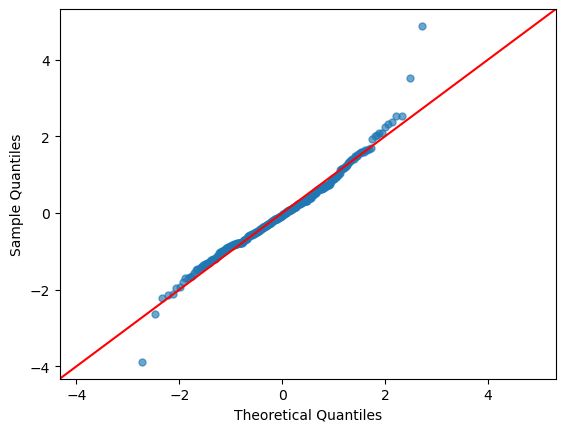

In [91]:
## Assessing normality of residuals Shapiro-Wilk test and QQ-plot
# Null hypothesis: residuals follow a normal distribution
residuals_lr = results_lr.resid
print(shapiro(residuals_lr))
ks_test = kstest(residuals_lr, 'norm', args=(np.mean(residuals_lr), np.std(residuals_lr)))
print(f"Kolmogorov-Smirnov test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
fig = sm.qqplot(residuals_lr, fit=True, line="45", alpha=0.65, markersize=5)
plt.show()

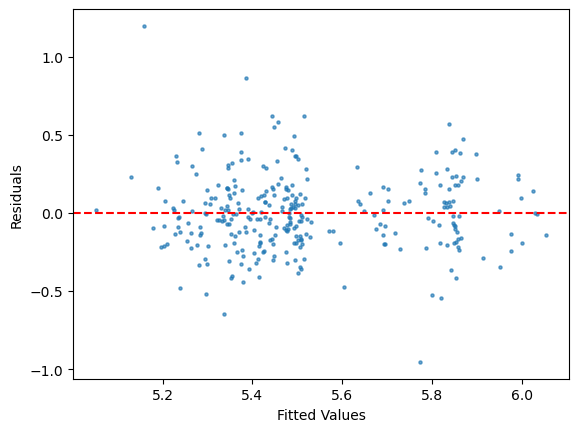

In [92]:
## Assessing linearity: Residual plot
fitted_values_lr = results_lr.fittedvalues
#plt.scatter(fitted_values_lr, np.sqrt(np.abs(residuals_lr/np.std(residuals_lr))), alpha=0.65, s=0.5)
plt.scatter(fitted_values_lr, residuals_lr, alpha=0.65, s=5)
plt.axhline(y=0, color='red', label='y=0', linestyle="--", linewidth=1.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

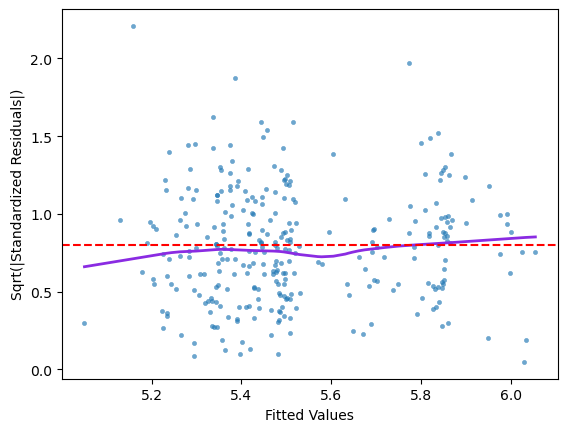

In [93]:
## Assessing homoscedasticity: Residual plot
import seaborn as sns

# Obtain fitted values and residuals from your model
residuals_lr = results_lr.resid

# Standardize residuals
standardized_residuals_lr = residuals_lr / np.std(residuals_lr)

# Compute square root of absolute standardized residuals
sqrt_abs_resid_lr = np.sqrt(np.abs(standardized_residuals_lr))

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Fitted Values': fitted_values_lr,
    'Sqrt Abs Standardized Residuals': sqrt_abs_resid_lr
})

# Create the Scale-Location plot with LOESS line
#plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fitted Values', y='Sqrt Abs Standardized Residuals', data=data, alpha=0.65, s=10, edgecolor='#1f77b4')
sns.regplot(x='Fitted Values', y='Sqrt Abs Standardized Residuals', data=data, scatter=False, 
            lowess=True, color="blueviolet", line_kws=dict(linestyle="-", linewidth=2))
plt.axhline(y=np.sqrt(2/np.pi), color='red', linestyle='--', lw=1.5)
plt.xlabel("Fitted Values")
plt.ylabel("Sqrt(|Standardized Residuals|)")
#plt.title("Scale-Location Plot with LOESS Smoothing")
#plt.legend()
plt.show()

In [106]:
### Establishing study case

# Scaled variables: ["TWI", "Bayesian_avg_H", "Bayes_mean_A" , 
# "Bayes_mean_R", "Review_count_H", "Score_H", "location_score"]

# Fitted variables: n_rooms_quant_0 + Hotel_class_3 + Hotel_class_45 + 
# Walkability_num_2 + Walkability_num_4 + Walkability_num_5 + 
# Bayesian_avg_H + Review_count_H'

# Study case to be defined (categorical): n_rooms_quant_0, Hotel_class_3, Hotel_class_45, Walkability_num_2
# Walkability_num_4, Walkability_num_5
# Study case to be defined (numerical): Bayesian_avg_H (var1), Review_count_H (var4)

## Get the scale and center values for variables
# IQR:
scale_value1 = scaler.scale_[1]
scale_value3 = scaler.scale_[3]

# Median:
center_value1 = scaler.center_[1]
center_value3 = scaler.center_[3]

# Defining values for numerical variables (use following chunk as reference for these values)
var1 = 4.4110864289439835
var3 = 4.235482553976931

# Transform
transformed_value1 = (var1 - center_value1) / scale_value1
transformed_value3 = (var3 - center_value3) / scale_value3

print("transformed_value1:", transformed_value1, "transformed_value4:", transformed_value3)

transformed_value1: 0.0 transformed_value4: 0.0


In [95]:
df_dummies.median()

Metro_Tram_stop                       1.000000
Closeness_Centrality_Attractions      0.000736
Closeness_Centrality_Restaurants      0.000756
Review_count_H                        0.000000
Score_H                               0.000000
Bayesian_avg_H                        0.000000
avg_price                           243.500000
avg_price_log                         5.495117
price_5_6_august                    188.000000
price_range_min                     188.000000
price_range_max                     299.000000
location_score                        0.000000
Bayes_mean_A                          0.000000
Bayes_mean_R                          0.000000
TWI                                   0.000000
Hotel_class_3                         0.000000
n_rooms_quant_0                       0.000000
n_rooms_quant_1                       0.000000
n_rooms_quant_2                       0.000000
n_rooms_quant_3                       0.000000
Walkability_num_1                     0.000000
Walkability_n

In [107]:
## Defining study case
study_case = [0, 0, transformed_value1, transformed_value3]

In [108]:
new_data = pd.DataFrame({'const':[1],
                         "Hotel_class_3":study_case[0],
                         "Hotel_class_45":study_case[1],
                         "Bayesian_avg_H":study_case[2],
                         "Bayes_mean_R":study_case[3],
})
predictions = results_lr.get_prediction(new_data)
df_predictions = predictions.summary_frame()
np.exp(df_predictions)

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  209.878232  1.030614     197.785453     222.710375     128.50585   

   obs_ci_upper  
0    342.777175

In [ ]:
x_walk_score = ["Poor", "Basic", "Average", "High", "Excellent"]
point_estimate_y0 = []
point_estimate_y = []
point_estimate_y2 = []

In [ ]:
# Create DataFrame
df_point_estimate = pd.DataFrame({
    "Walkability": x_walk_score,
    "point_estimate_y45": point_estimate_y2,
    "point_estimate_y3": point_estimate_y, 
    "point_estimate_y12": point_estimate_y0
})

# Plot the DataFrame
ax = df_point_estimate.plot.bar(x="Walkability", y=["point_estimate_y12", "point_estimate_y3", "point_estimate_y45"], 
                 color=["#ff7f0e", "#1f77b4", "#2ca02c"], alpha=0.65, 
                 xlabel="Walkability", ylabel="Price", rot=0)
ax.set_ylim([0, 200])

# Add labels and title
plt.xlabel("Walkability")
plt.ylabel("Price")
#plt.title("Comparison of Counts by Walkability Levels")
plt.legend(["1/2 stars", "3 stars", "4/5 stars"])

# Show plot
plt.show()

In [94]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor, export_graphviz  
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [111]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a regressor object 
## Using GridSearchCV over min_samples_leaf
regressor = DecisionTreeRegressor(random_state = 42)

# Define X and y data 
df_dummies_dropna = df_dummies.dropna(subset="avg_price_log")
var_considered = [
"n_rooms_quant_1", "n_rooms_quant_2", "n_rooms_quant_3",
              "Hotel_class_3", "Hotel_class_45", 
              "Walkability_num_2", "Walkability_num_3", "Walkability_num_4", 
               "Walkability_num_5", "Bayesian_avg_H", 
                  "Bayes_mean_A", "Bayes_mean_R", "Review_count_H"]
X=df_dummies_dropna[var_considered]

# "Closeness_Centrality_Restaurants", "Closeness_Centrality_Restaurants",
y=df_dummies_dropna.avg_price_log

# Split the data into training and testing sets (80-20 split)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the grid for min_samples_leaf
#param_grid = {"min_samples_leaf":[2]} # 
param_grid = {
    'max_depth': np.arange(1, 2), # np.arange(5, 16)
    #'min_samples_split': np.arange(10, 100),
    'min_samples_leaf': np.arange(9, 10) # np.arange(5, 15)
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=10, scoring="r2")

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameter value
best_max_depth = grid_search.best_params_["max_depth"]
#best_min_samples_split = grid_search.best_params_["min_samples_split"]
best_min_samples_leaf = grid_search.best_params_["min_samples_leaf"]
print(f"Best max_depth: {best_max_depth}")
#print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Fit the final model with the best min_samples_leaf
final_model = DecisionTreeRegressor(max_depth = best_max_depth, 
                                    min_samples_leaf=best_min_samples_leaf)
final_model.fit(X, y)

# Predict the entire dataset
y_pred = final_model.predict(X)

# Calculate evalation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

#mse_scores = -cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")
#r2_scores = cross_val_score(final_model, X, y, cv=5, scoring="r2")

# Calculate mean and std of MSE
#mean_mse_scores = np.mean(mse_scores)
#std_mse_scores = np.std(mse_scores)
#mean_r2_scores = np.mean(r2_scores)
#std_r2_scores = np.std(r2_scores)

#print(f"Mean MSE: {mean_mse_scores}")
#print(f"Std MSE: {std_mse_scores}")
#print(f"Mean R^2: {mean_r2_scores}")
#print(f"Std R^2: {std_r2_scores}")

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Adj R^2: {1-(1-r2)*(len(X)-1)/(len(X)-len(var_considered)-1)}")

Best max_depth: 1
Best min_samples_leaf: 9
MSE: 0.07138839910638213
R^2: 0.33687208449779604
Adj R^2: 0.3068349315307972


In [112]:
print("mean_test_score:" , grid_search.cv_results_["mean_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])
print("std_test_score:" , grid_search.cv_results_["std_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])
print("rank_test_score:" , grid_search.cv_results_["rank_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])

mean_test_score: 0.2991656531889597
std_test_score: 0.17209462779655793
rank_test_score: 1


In [1496]:
# Predict on the testing data (if train_test_split in the previous chunk is uncommented)
#y_pred = final_model.predict(X_test)

# Calculate evaluation metrics on the testing data
#mse = mean_squared_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)
#adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(var_considered) - 1)

#print(f"MSE: {mse}")
#print(f"R^2: {r2}")
#print(f"Adjusted R^2: {adj_r2}")

In [121]:
# Feature importance
j = 0
var_considered_filtered = []
for feature in var_considered:
    print(feature, final_model.feature_importances_[j])
    
    if final_model.feature_importances_[j] > 0:
        var_considered_filtered.append(feature)
        
    j += 1

n_rooms_quant_1 0.0
n_rooms_quant_2 0.0
n_rooms_quant_3 0.0
Hotel_class_3 0.02225509382108032
Hotel_class_45 0.6441431263553552
Bayesian_avg_H 0.1735505529523323
Bayes_mean_A 0.03765404338570335
Bayes_mean_R 0.017850692541329913
TWI 0.0836586093347445
Review_count_H 0.02088788160945428


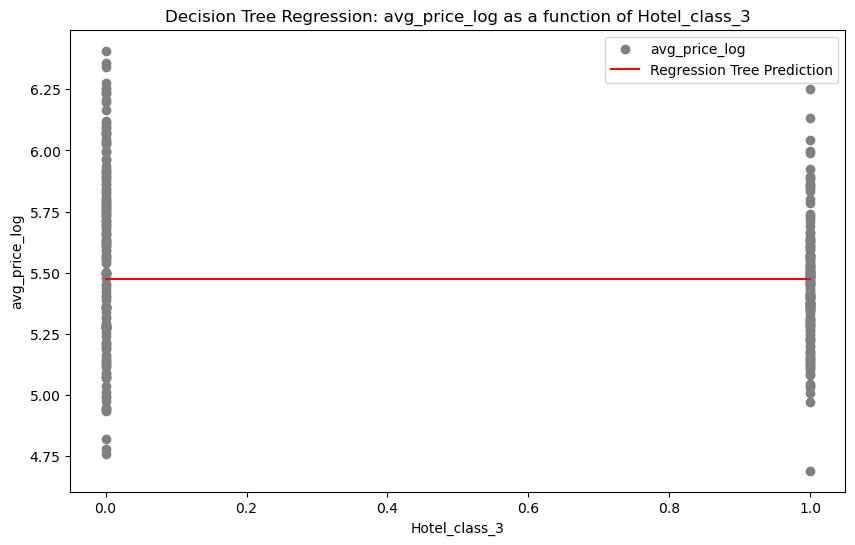

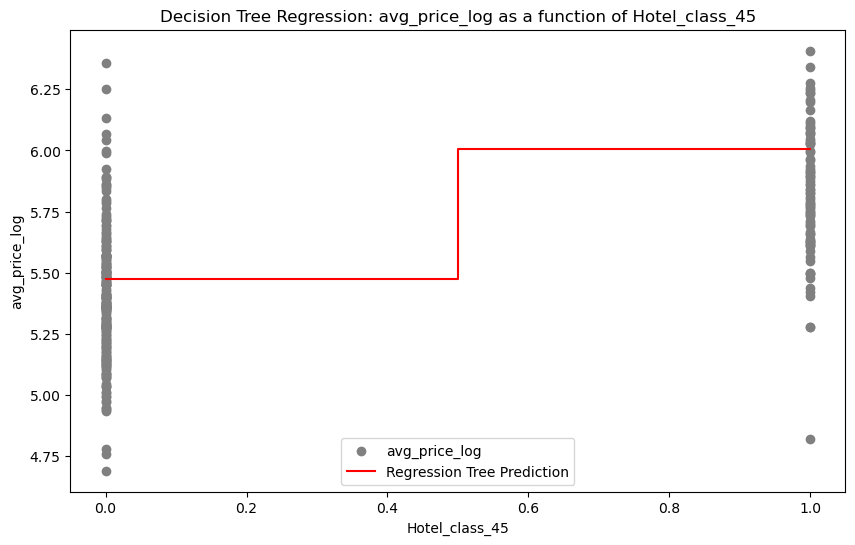

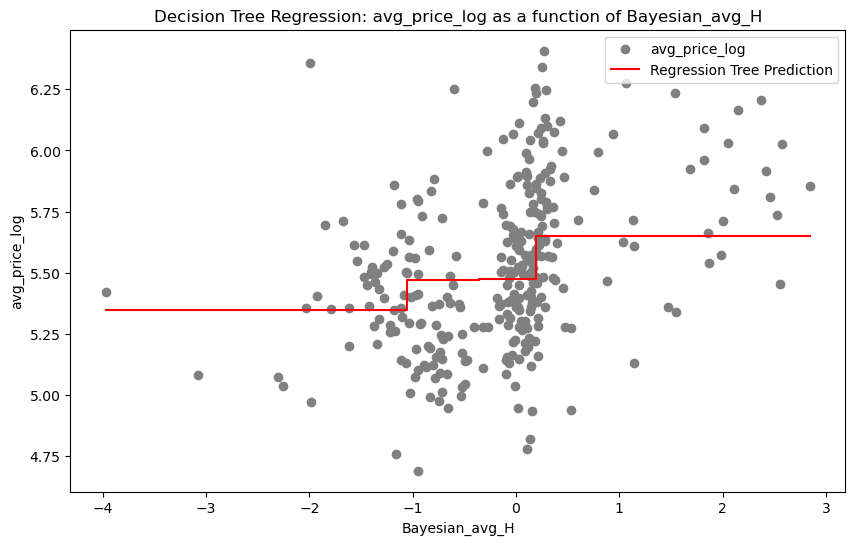

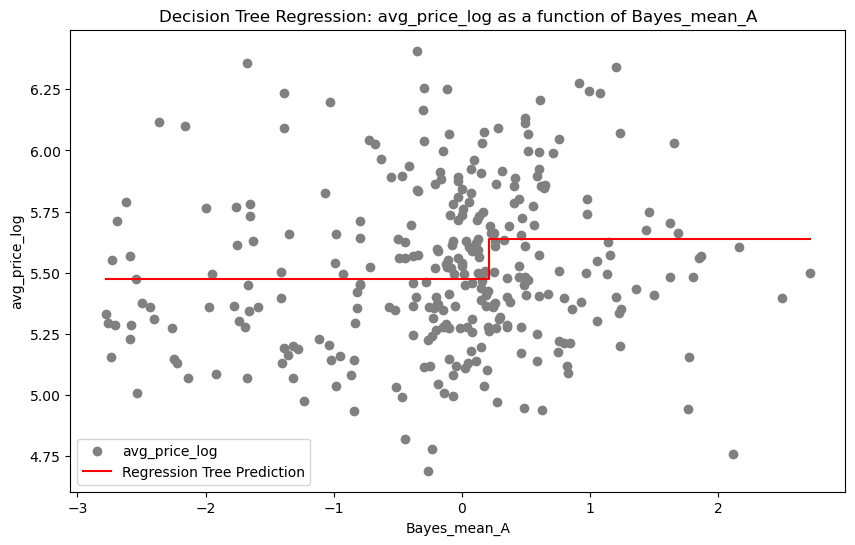

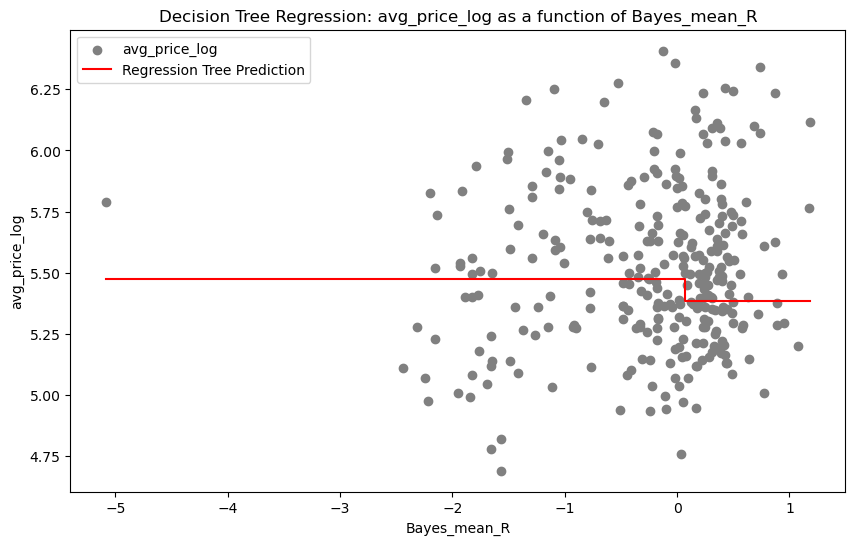

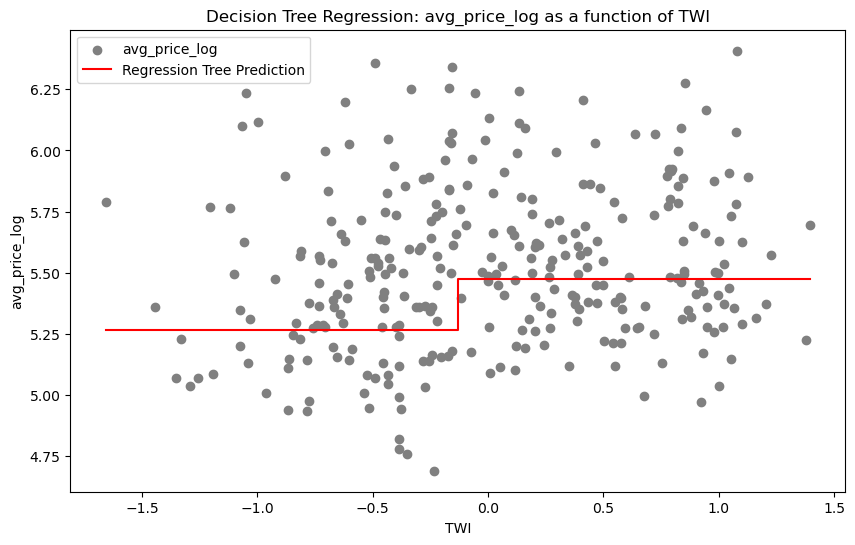

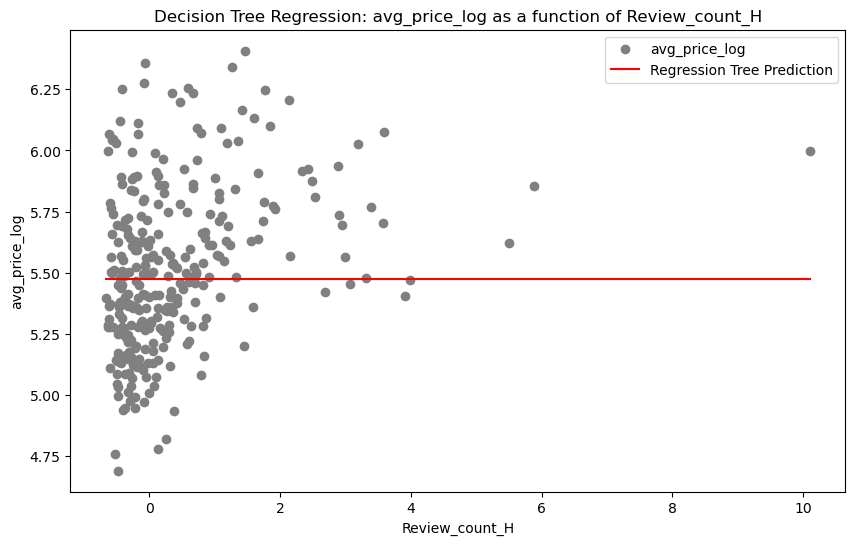

In [122]:
# Function to plot the decision tree predictions for a given feature
def plot_feature_decision_boundary(feature_name, output_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot of the feature vs avg_price
    plt.scatter(X[feature_name], y, color='gray', label=output_label)

    # Create a grid of feature values
    feature_values = np.linspace(X[feature_name].min(), X[feature_name].max(), 500)

    # Create a grid of input features
    X_grid = pd.DataFrame(np.tile(X.mean().values, (500, 1)), columns=X.columns)
    X_grid[feature_name] = feature_values

    # Predict avg_price for the grid values
    y_grid_pred = final_model.predict(X_grid)

    # Plot the decision boundary
    plt.step(feature_values, y_grid_pred, color='red', label='Regression Tree Prediction', where='mid')

    plt.xlabel(feature_name)
    plt.ylabel(output_label)
    plt.title(f"Decision Tree Regression: {output_label} as a function of {feature_name}")
    plt.legend()
    plt.show()

# Plot decision boundaries for each feature
for feature in var_considered_filtered:
    plot_feature_decision_boundary(feature, "avg_price_log")

In [1499]:
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
# https://dreampuf.github.io/GraphvizOnline/#digraph%20Tree%20%7B%0D%0Anode%20%5Bshape%3Dbox%2C%20fontname%3D%22helvetica%22%5D%20%3B%0D%0Aedge%20%5Bfontname%3D%22helvetica%22%5D%20%3B%0D%0A0%20%5Blabel%3D%22TWI%20%3C%3D%208.771%5Cnsquared_error%20%3D%20454.476%5Cnsamples%20%3D%2018%5Cnvalue%20%3D%20117.694%22%5D%20%3B%0D%0A1%20%5Blabel%3D%22Hotel_class_23%20%3C%3D%200.5%5Cnsquared_error%20%3D%2062.776%5Cnsamples%20%3D%207%5Cnvalue%20%3D%2098.286%22%5D%20%3B%0D%0A0%20-%3E%201%20%5Blabeldistance%3D2.5%2C%20labelangle%3D45%2C%20headlabel%3D%22True%22%5D%20%3B%0D%0A2%20%5Blabel%3D%22TWI%20%3C%3D%200.954%5Cnsquared_error%20%3D%2019.297%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20104.375%22%5D%20%3B%0D%0A1%20-%3E%202%20%3B%0D%0A3%20%5Blabel%3D%22squared_error%20%3D%2033.062%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20102.75%22%5D%20%3B%0D%0A2%20-%3E%203%20%3B%0D%0A4%20%5Blabel%3D%22squared_error%20%3D%200.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20106.0%22%5D%20%3B%0D%0A2%20-%3E%204%20%3B%0D%0A5%20%5Blabel%3D%22squared_error%20%3D%205.389%5Cnsamples%20%3D%203%5Cnvalue%20%3D%2090.167%22%5D%20%3B%0D%0A1%20-%3E%205%20%3B%0D%0A6%20%5Blabel%3D%22Hotel_class_23%20%3C%3D%200.5%5Cnsquared_error%20%3D%20311.475%5Cnsamples%20%3D%2011%5Cnvalue%20%3D%20130.045%22%5D%20%3B%0D%0A0%20-%3E%206%20%5Blabeldistance%3D2.5%2C%20labelangle%3D-45%2C%20headlabel%3D%22False%22%5D%20%3B%0D%0A7%20%5Blabel%3D%22squared_error%20%3D%20269.389%5Cnsamples%20%3D%203%5Cnvalue%20%3D%20150.333%22%5D%20%3B%0D%0A6%20-%3E%207%20%3B%0D%0A8%20%5Blabel%3D%22TWI%20%3C%3D%2059.023%5Cnsquared_error%20%3D%20115.027%5Cnsamples%20%3D%208%5Cnvalue%20%3D%20122.438%22%5D%20%3B%0D%0A6%20-%3E%208%20%3B%0D%0A9%20%5Blabel%3D%22TWI%20%3C%3D%2039.613%5Cnsquared_error%20%3D%204.922%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20129.625%22%5D%20%3B%0D%0A8%20-%3E%209%20%3B%0D%0A10%20%5Blabel%3D%22squared_error%20%3D%200.562%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20129.25%22%5D%20%3B%0D%0A9%20-%3E%2010%20%3B%0D%0A11%20%5Blabel%3D%22squared_error%20%3D%209.0%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20130.0%22%5D%20%3B%0D%0A9%20-%3E%2011%20%3B%0D%0A12%20%5Blabel%3D%22TWI%20%3C%3D%2071.824%5Cnsquared_error%20%3D%20121.812%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20115.25%22%5D%20%3B%0D%0A8%20-%3E%2012%20%3B%0D%0A13%20%5Blabel%3D%22squared_error%20%3D%20240.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20114.5%22%5D%20%3B%0D%0A12%20-%3E%2013%20%3B%0D%0A14%20%5Blabel%3D%22squared_error%20%3D%202.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20116.0%22%5D%20%3B%0D%0A12%20-%3E%2014%20%3B%0D%0A%7D
export_graphviz(final_model, out_file ='tree_Venezia_avg_price_log.dot', 
               feature_names = var_considered)  

#### GAM

In [123]:
GAM_fit = True
if GAM_fit:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

GAM R²: 0.4719871735577462


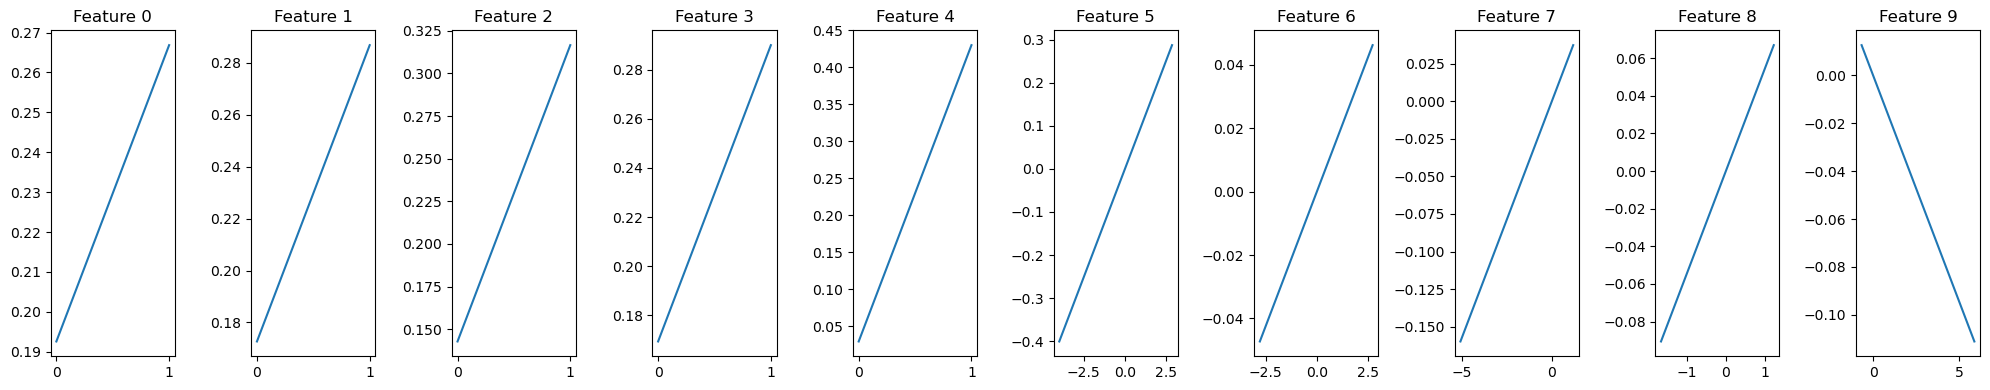

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.9759
Link Function:                     IdentityLink Log Likelihood:                                 -1407.6147
Number of Samples:                          240 AIC:                                             2839.1811
                                                AICc:                                            2840.5501
                                                GCV:                                                0.0672
                                                Scale:                                              0.0617
                                                Pseudo R-Squared:                                   0.4506
Feature Function                  Lam

C:\Users\mario\AppData\Local\Temp\ipykernel_18932\513038979.py:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [135]:
# Install pyGAM
# !pip install pygam
if GAM_fit:
    from pygam import LinearGAM, s, f, l

    # Fit GAM model
    #gam = LinearGAM(s(0)  + s(1) + s(2) + s(3, basis='ps') + s(4, basis='ps') + s(5) + s(6, basis='ps')).fit(X, y)

    X=X[["n_rooms_quant_1", "n_rooms_quant_2", "n_rooms_quant_3", "Hotel_class_3", "Hotel_class_45", "Bayesian_avg_H", "Bayes_mean_A", "Bayes_mean_R", "TWI", "Review_count_H"]] #, "Bayesian_avg_mean_A_Z"
    X_test=X_test[["n_rooms_quant_1", "n_rooms_quant_2", "n_rooms_quant_3", "Hotel_class_3", "Hotel_class_45", "Bayesian_avg_H", "Bayes_mean_A", "Bayes_mean_R", "TWI", "Review_count_H"]] #, "Bayesian_avg_mean_A_Z"
    gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + l(5) + l(6) + l(7) + l(8) + l(9)).fit(X, y)

    y_pred_gam = gam.predict(X_test)
    r2_gam = r2_score(y_test, y_pred_gam)
    print(f"GAM R²: {r2_gam}")

    # Plot the partial dependence
    fig, axs = plt.subplots(1, X.shape[1], figsize=(20, 4))
    for i, ax in enumerate(axs):
        XX = gam.generate_X_grid(term=i)
        ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
        ax.set_title(f'Feature {i}')
    plt.tight_layout()
    plt.show()
    print(gam.summary())

#### Gradient Boosting

In [136]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Define X and y data 
df_dummies_dropna = df_dummies.dropna(subset=["avg_price_log"])

var_considered = ["n_rooms_quant_1", "n_rooms_quant_2", "n_rooms_quant_3", 
                  "Hotel_class_3", "Hotel_class_45", "Bayesian_avg_H", "Bayes_mean_A", 
                  "Bayes_mean_R", "TWI", "Review_count_H"]

X = df_dummies_dropna[var_considered]
y = df_dummies_dropna["avg_price_log"]

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the grid for Gradient Boosting parameters
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': np.arange(3, 15),
    'min_samples_leaf': np.arange(3, 15)
}

# Create a Gradient Boosting regressor object
gb_regressor = GradientBoostingRegressor(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_n_estimators = grid_search.best_params_["n_estimators"]
best_learning_rate = grid_search.best_params_["learning_rate"]
best_max_depth = grid_search.best_params_["max_depth"]
best_min_samples_leaf = grid_search.best_params_["min_samples_leaf"]

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Fit the final model with the best parameters
final_model = GradientBoostingRegressor(
    n_estimators=best_n_estimators, 
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict the test set
y_pred = final_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - len(var_considered) - 1)

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Adj R^2: {adj_r2}")

Best n_estimators: 500
Best learning_rate: 0.01
Best max_depth: 3
Best min_samples_leaf: 13
MSE: 0.06084287840939948
R^2: 0.4236776540915821
Adj R^2: 0.40380446974991246


#### Isochrone maps

C:\Users\mario\AppData\Local\Temp\ipykernel_15912\280278442.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_var)


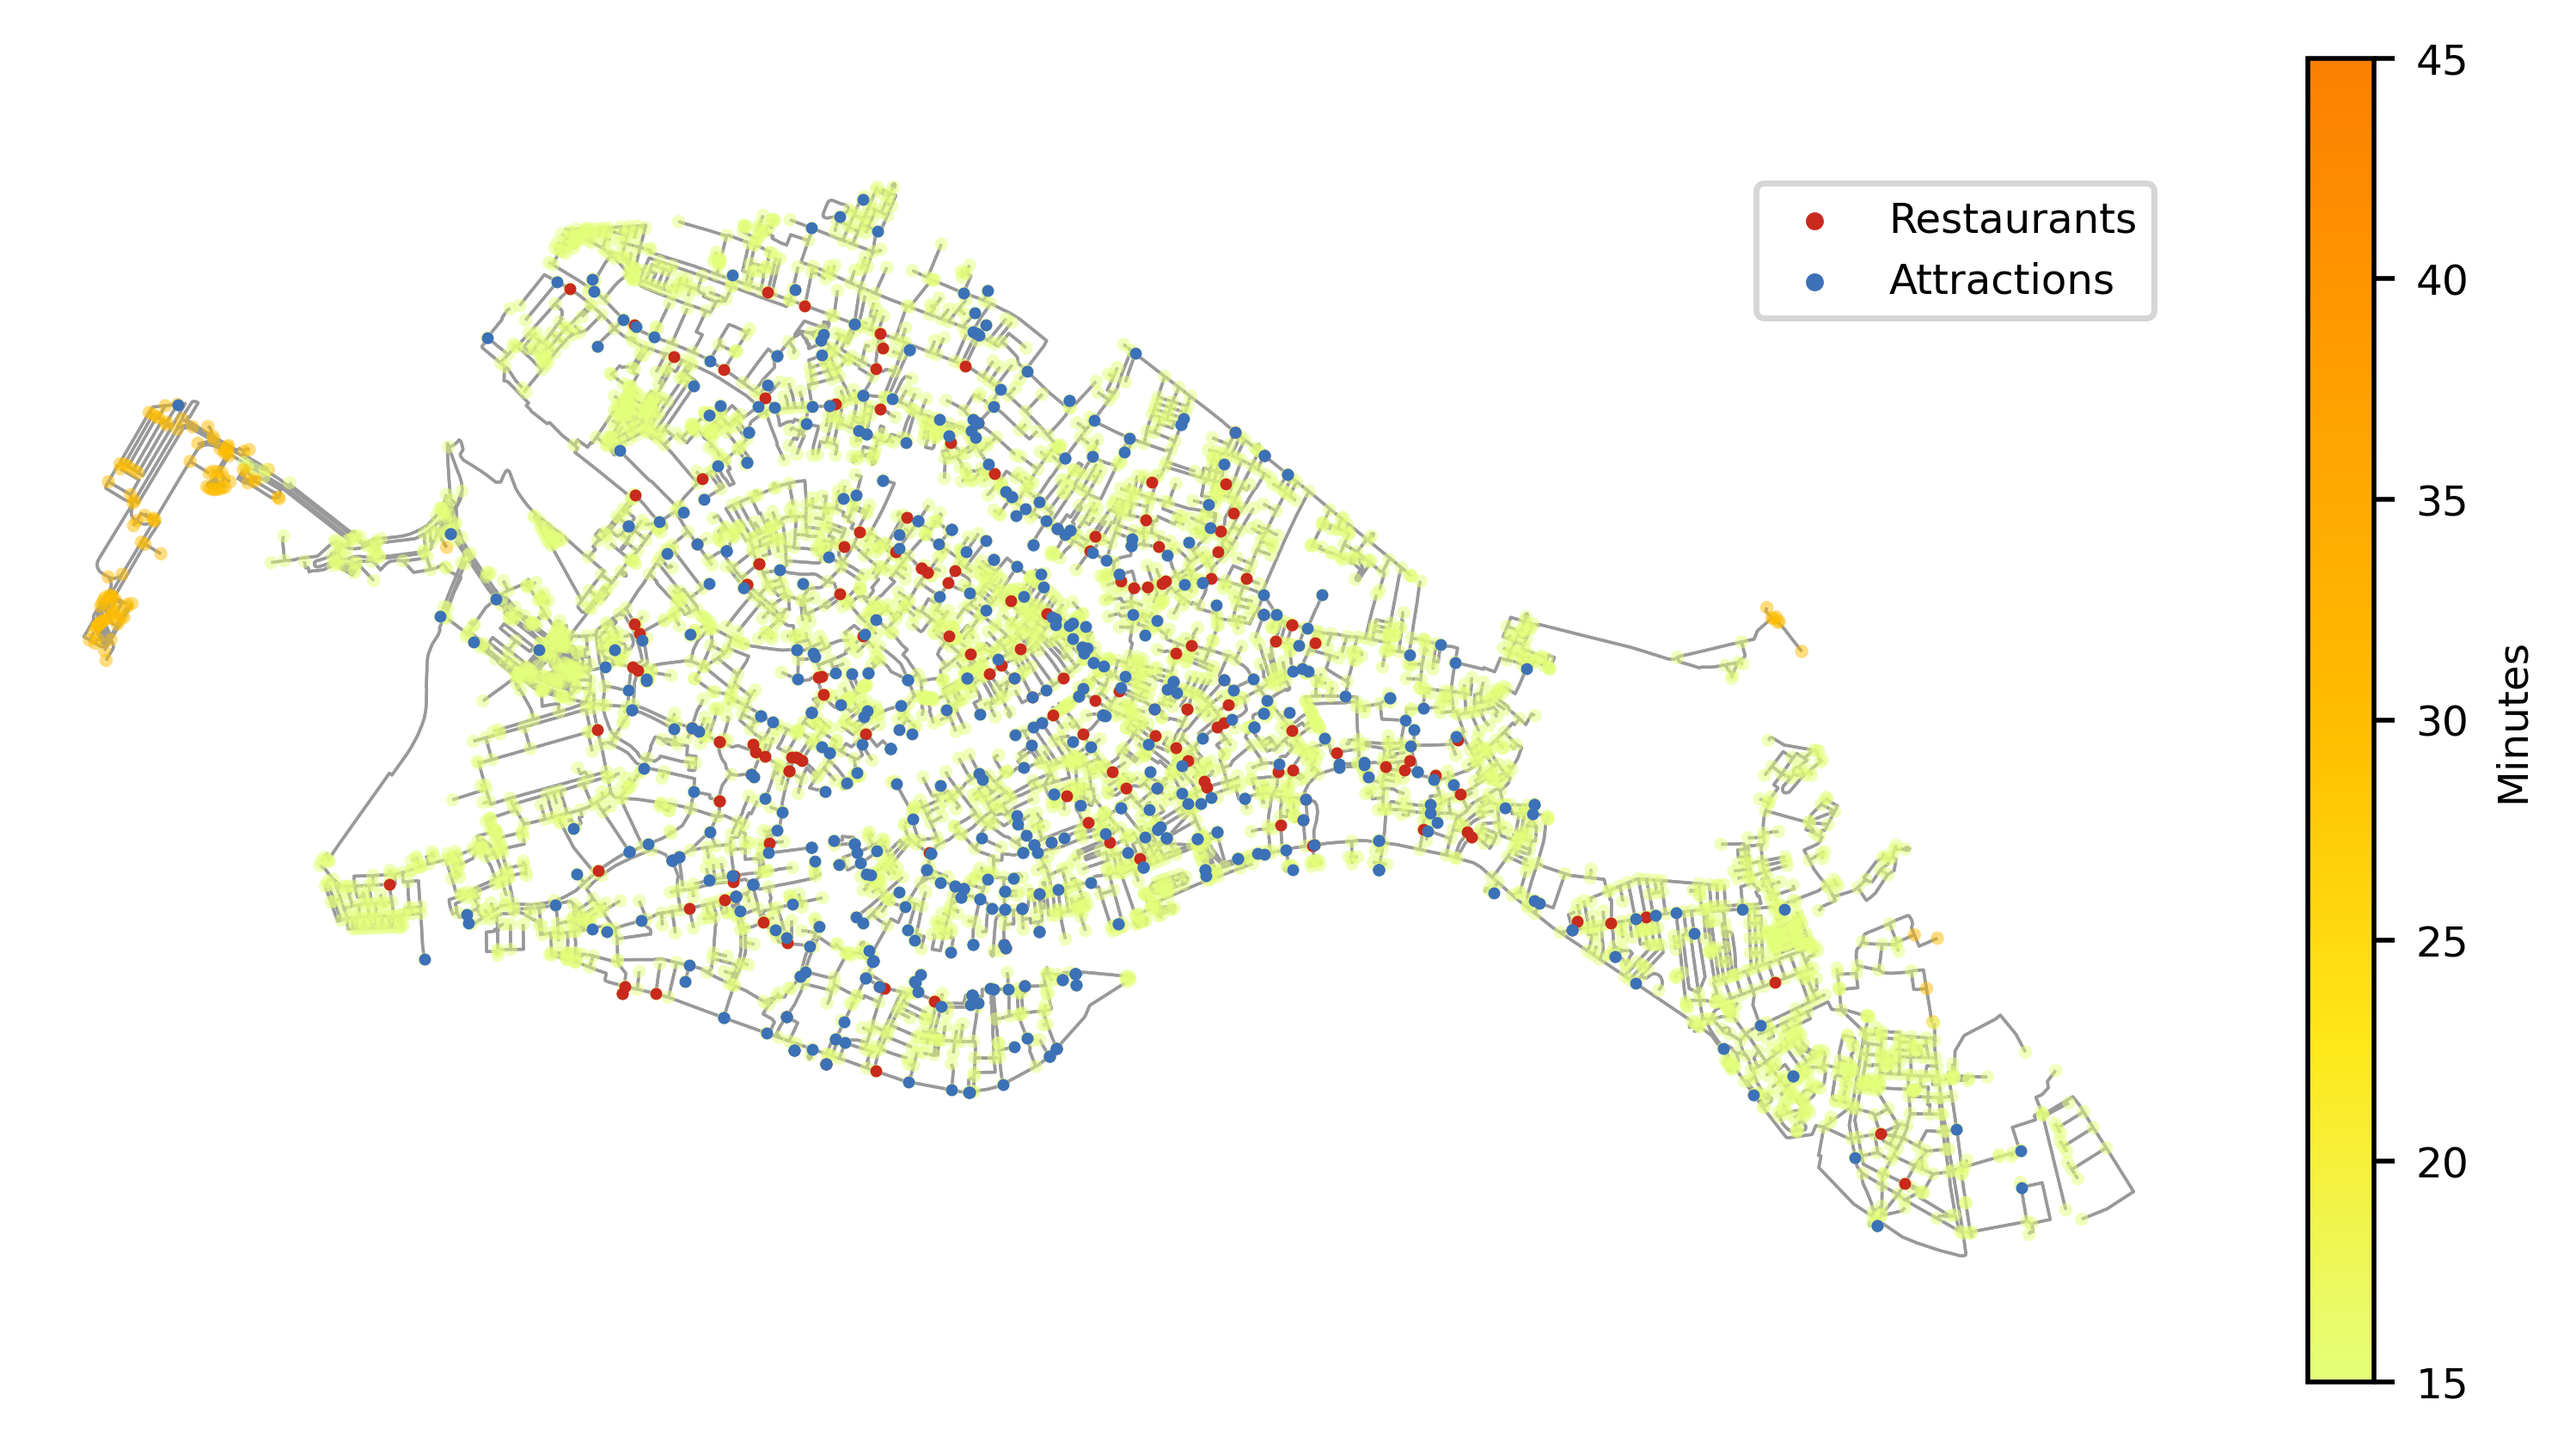

In [59]:
G2 = G
trip_times = [X_minutes, 30, 45]  # in minutes

cmap_var = "Wistia"#"Greens" #"Wistia"  #"summer" #
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G2.edges(data=True, keys=True):
    data["time"] = data["length"] / speed_mm
    
# get one color for each isochrone (r, g, b, alpha)
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap=cmap_var, start=1, stop=0, alpha = 1)
# color the nodes according to isochrone then plot the street network
node_colors = {}
node_time = {}

for center_node in hotels_df["id_nearest_node_H"]:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G2, center_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            if node in node_time and trip_time < node_time[node]:
                node_colors[node] = color
                node_time[node] = trip_time
            elif node not in node_time:
                node_colors[node] = color
                node_time[node] = trip_time
nc = [node_colors[node] if node in node_colors else "none" for node in G2.nodes()]
ns = [5 if node in node_colors else 0 for node in G2.nodes()]
mpl.rcParams['figure.dpi'] = 500

cmap = plt.cm.get_cmap(cmap_var)
norm = plt.Normalize(vmin=np.min(trip_times), vmax=np.max(trip_times))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


fig, ax = ox.plot_graph(G2, node_color=nc, node_size=ns, node_alpha=0.5,
                        edge_linewidth=0.5, edge_color="#999999", bgcolor="white", 
                        show=False, close=False)

    
# Adding Hotels, Restaurants, Attractions, and Tram/Metro stations
#ax.scatter(hotels_df["x_nearest_node_H"].values, hotels_df["y_nearest_node_H"].values, 
#           color='green', s=10, zorder=2, marker = 'o', label="Hotels")
ax.scatter(top_k_R_df["x_nearest_node_R"].values, top_k_R_df["y_nearest_node_R"].values, 
           color='#c82a1d', s=1, zorder=2, marker = 'o', label="Restaurants")
ax.scatter(top_k_A_df["x_nearest_node_A"].values, top_k_A_df["y_nearest_node_A"].values, 
           color='#3c71b7', s=1, zorder=2, marker = 'o', label="Attractions")
ax.legend(loc='upper right', fontsize = "x-small", markerscale = 2)

cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.5)
cb.ax.tick_params(labelsize=7)
cb.set_label('Minutes', fontsize = 7)

plt.show()

#### For plotting some auxiliary images

C:\Users\mario\AppData\Local\Temp\ipykernel_13400\1406735558.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_var)


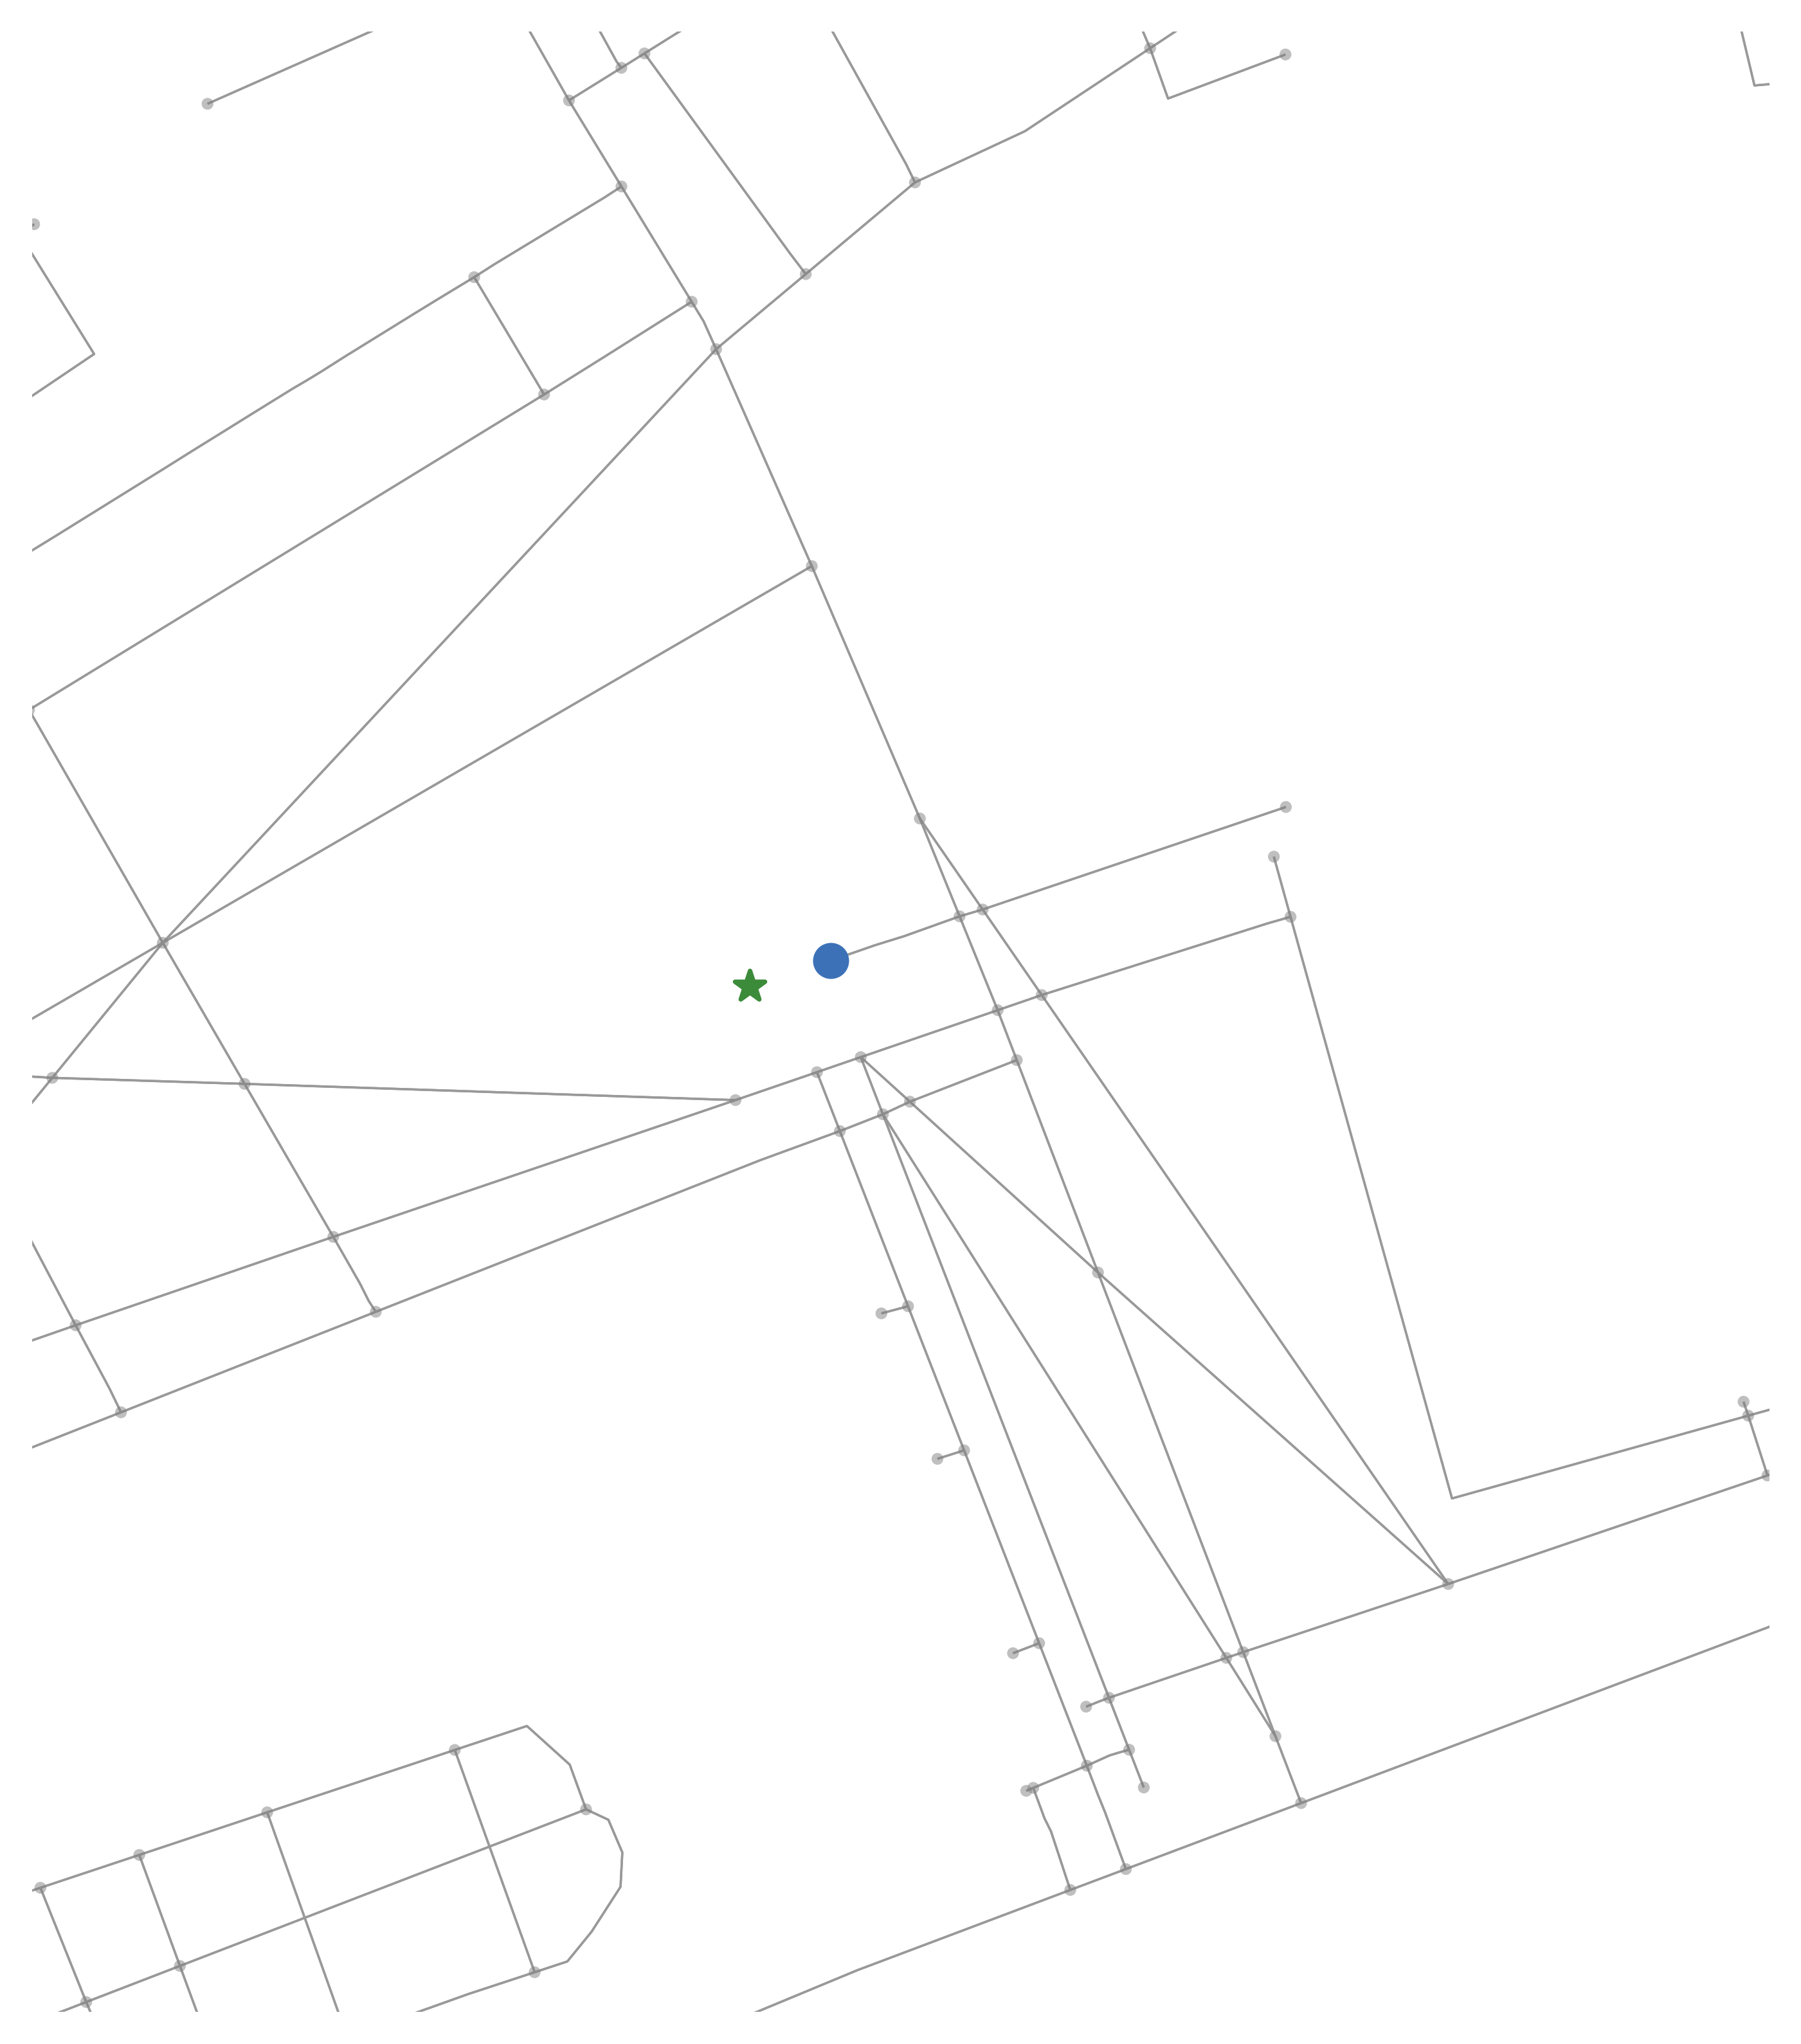

In [61]:
# Plotting Campanile di San Marco to show the mapping of nodes
# original node: 12.339033 45.434036          nearest node: 12.339149 45.434062

G2 = G
trip_times = [X_minutes]  # in minutes

cmap_var = "Wistia"#"Greens" #"Wistia"  #"summer" #
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G2.edges(data=True, keys=True):
    data["time"] = data["length"] / speed_mm
    
# get one color for each isochrone (r, g, b, alpha)
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap=cmap_var, start=1, stop=0, alpha = 1)
# color the nodes according to isochrone then plot the street network
node_colors = {}
node_time = {}

for center_node in hotels_df["id_nearest_node_H"]:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G2, center_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            if node in node_time and trip_time < node_time[node]:
                node_colors[node] = color
                node_time[node] = trip_time
            elif node not in node_time:
                node_colors[node] = color
                node_time[node] = trip_time
nc = ["gray" if node in node_colors else "none" for node in G2.nodes()]
ns = [7 if node in node_colors else 7 for node in G2.nodes()]
mpl.rcParams['figure.dpi'] = 500

cmap = plt.cm.get_cmap(cmap_var)
norm = plt.Normalize(vmin=np.min(trip_times), vmax=np.max(trip_times))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


fig, ax = ox.plot_graph(G2, node_color=nc, node_size=ns, node_alpha=0.5,
                        edge_linewidth=0.5, edge_color="#999999", bgcolor="white", 
                        show=False, close=False)

    
# Adding Hotels, Restaurants, Attractions, and Tram/Metro stations
#ax.scatter(hotels_df["x_nearest_node_H"].values, hotels_df["y_nearest_node_H"].values, 
#           color='green', s=10, zorder=2, marker = 'o', label="Hotels")
# Nearest node
ax.scatter(12.339149, 45.434062, 
           color='#3c71b7', s=50, zorder=2, marker = 'o')

# Original node
ax.scatter(12.339033, 45.434036, 
           color='#3c8b3a', s=50, zorder=2, marker = '*')

# Set zoom (xlim and ylim to focus on the desired area)
#ax.set_xlim(12.336, 12.342)  # Narrower range for a moderate zoom in
#ax.set_ylim(45.432, 45.436)  # Narrower range for a moderate zoom in
ax.set_xlim(12.3380, 12.3405)  # Much wider range for minimal zoom
ax.set_ylim(45.4330, 45.4350)  # Much wider range for minimal zoom



#ax.legend(loc='upper right', fontsize = "x-small", markerscale = 2)

#cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.5)
#cb.ax.tick_params(labelsize=7)
#cb.set_label('Minutes', fontsize = 7)

plt.show()

In [85]:
H_A_df[(H_A_df.name_A=="Campanile di San Marco")].sort_values(by="SP_dist_minutes").iloc[1, :]

name_H                      Hotel Concordia
name_A               Campanile di San Marco
SP_dist_minutes                    2.854083
gcode_H                             g187870
dcode_H                             d229059
score_H                                 4.5
review_count_H                         1413
x_H                                12.33944
y_H                               45.435114
id_nearest_node_H                  31317919
x_nearest_node_H                  12.339472
y_nearest_node_H                  45.435206
istat_pro_com_H                       27042
municipality_H                      Venezia
hotel_class                             4.0
type_H                                Hotel
price_5_6_august                      242.0
price_range_min                       241.0
price_range_max                       479.0
avg_price                             360.0
n_rooms                                51.0
location_score                          4.9
Bayesian_avg_H                  

In [86]:
H_A_df[(H_A_df.name_H=="Hotel Concordia")].sort_values(by="SP_dist_minutes")[H_A_df.name_A=="Basilica di San Marco"].iloc[0, :]

C:\Users\mario\AppData\Local\Temp\ipykernel_11488\2811602756.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  H_A_df[(H_A_df.name_H=="Hotel Concordia")].sort_values(by="SP_dist_minutes")[H_A_df.name_A=="Basilica di San Marco"].iloc[0, :]


name_H                     Hotel Concordia
name_A               Basilica di San Marco
SP_dist_minutes                   3.206933
gcode_H                            g187870
dcode_H                            d229059
score_H                                4.5
review_count_H                        1413
x_H                               12.33944
y_H                              45.435114
id_nearest_node_H                 31317919
x_nearest_node_H                 12.339472
y_nearest_node_H                 45.435206
istat_pro_com_H                      27042
municipality_H                     Venezia
hotel_class                            4.0
type_H                               Hotel
price_5_6_august                     242.0
price_range_min                      241.0
price_range_max                      479.0
avg_price                            360.0
n_rooms                               51.0
location_score                         4.9
Bayesian_avg_H                     4.45199
gcode_A    

In [101]:
H_A_df[(H_A_df.name_H=="Hotel Concordia")].sort_values(by="SP_dist_minutes")[H_A_df.name_A=="Chiesa Di Santa Sofia"].iloc[0, :]

C:\Users\mario\AppData\Local\Temp\ipykernel_11488\3374761701.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  H_A_df[(H_A_df.name_H=="Hotel Concordia")].sort_values(by="SP_dist_minutes")[H_A_df.name_A=="Chiesa Di Santa Sofia"].iloc[0, :]


name_H                     Hotel Concordia
name_A               Chiesa Di Santa Sofia
SP_dist_minutes                    15.4192
gcode_H                            g187870
dcode_H                            d229059
score_H                                4.5
review_count_H                        1413
x_H                               12.33944
y_H                              45.435114
id_nearest_node_H                 31317919
x_nearest_node_H                 12.339472
y_nearest_node_H                 45.435206
istat_pro_com_H                      27042
municipality_H                     Venezia
hotel_class                            4.0
type_H                               Hotel
price_5_6_august                     242.0
price_range_min                      241.0
price_range_max                      479.0
avg_price                            360.0
n_rooms                               51.0
location_score                         4.9
Bayesian_avg_H                     4.45199
gcode_A    

C:\Users\mario\AppData\Local\Temp\ipykernel_11488\4043285063.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_var)


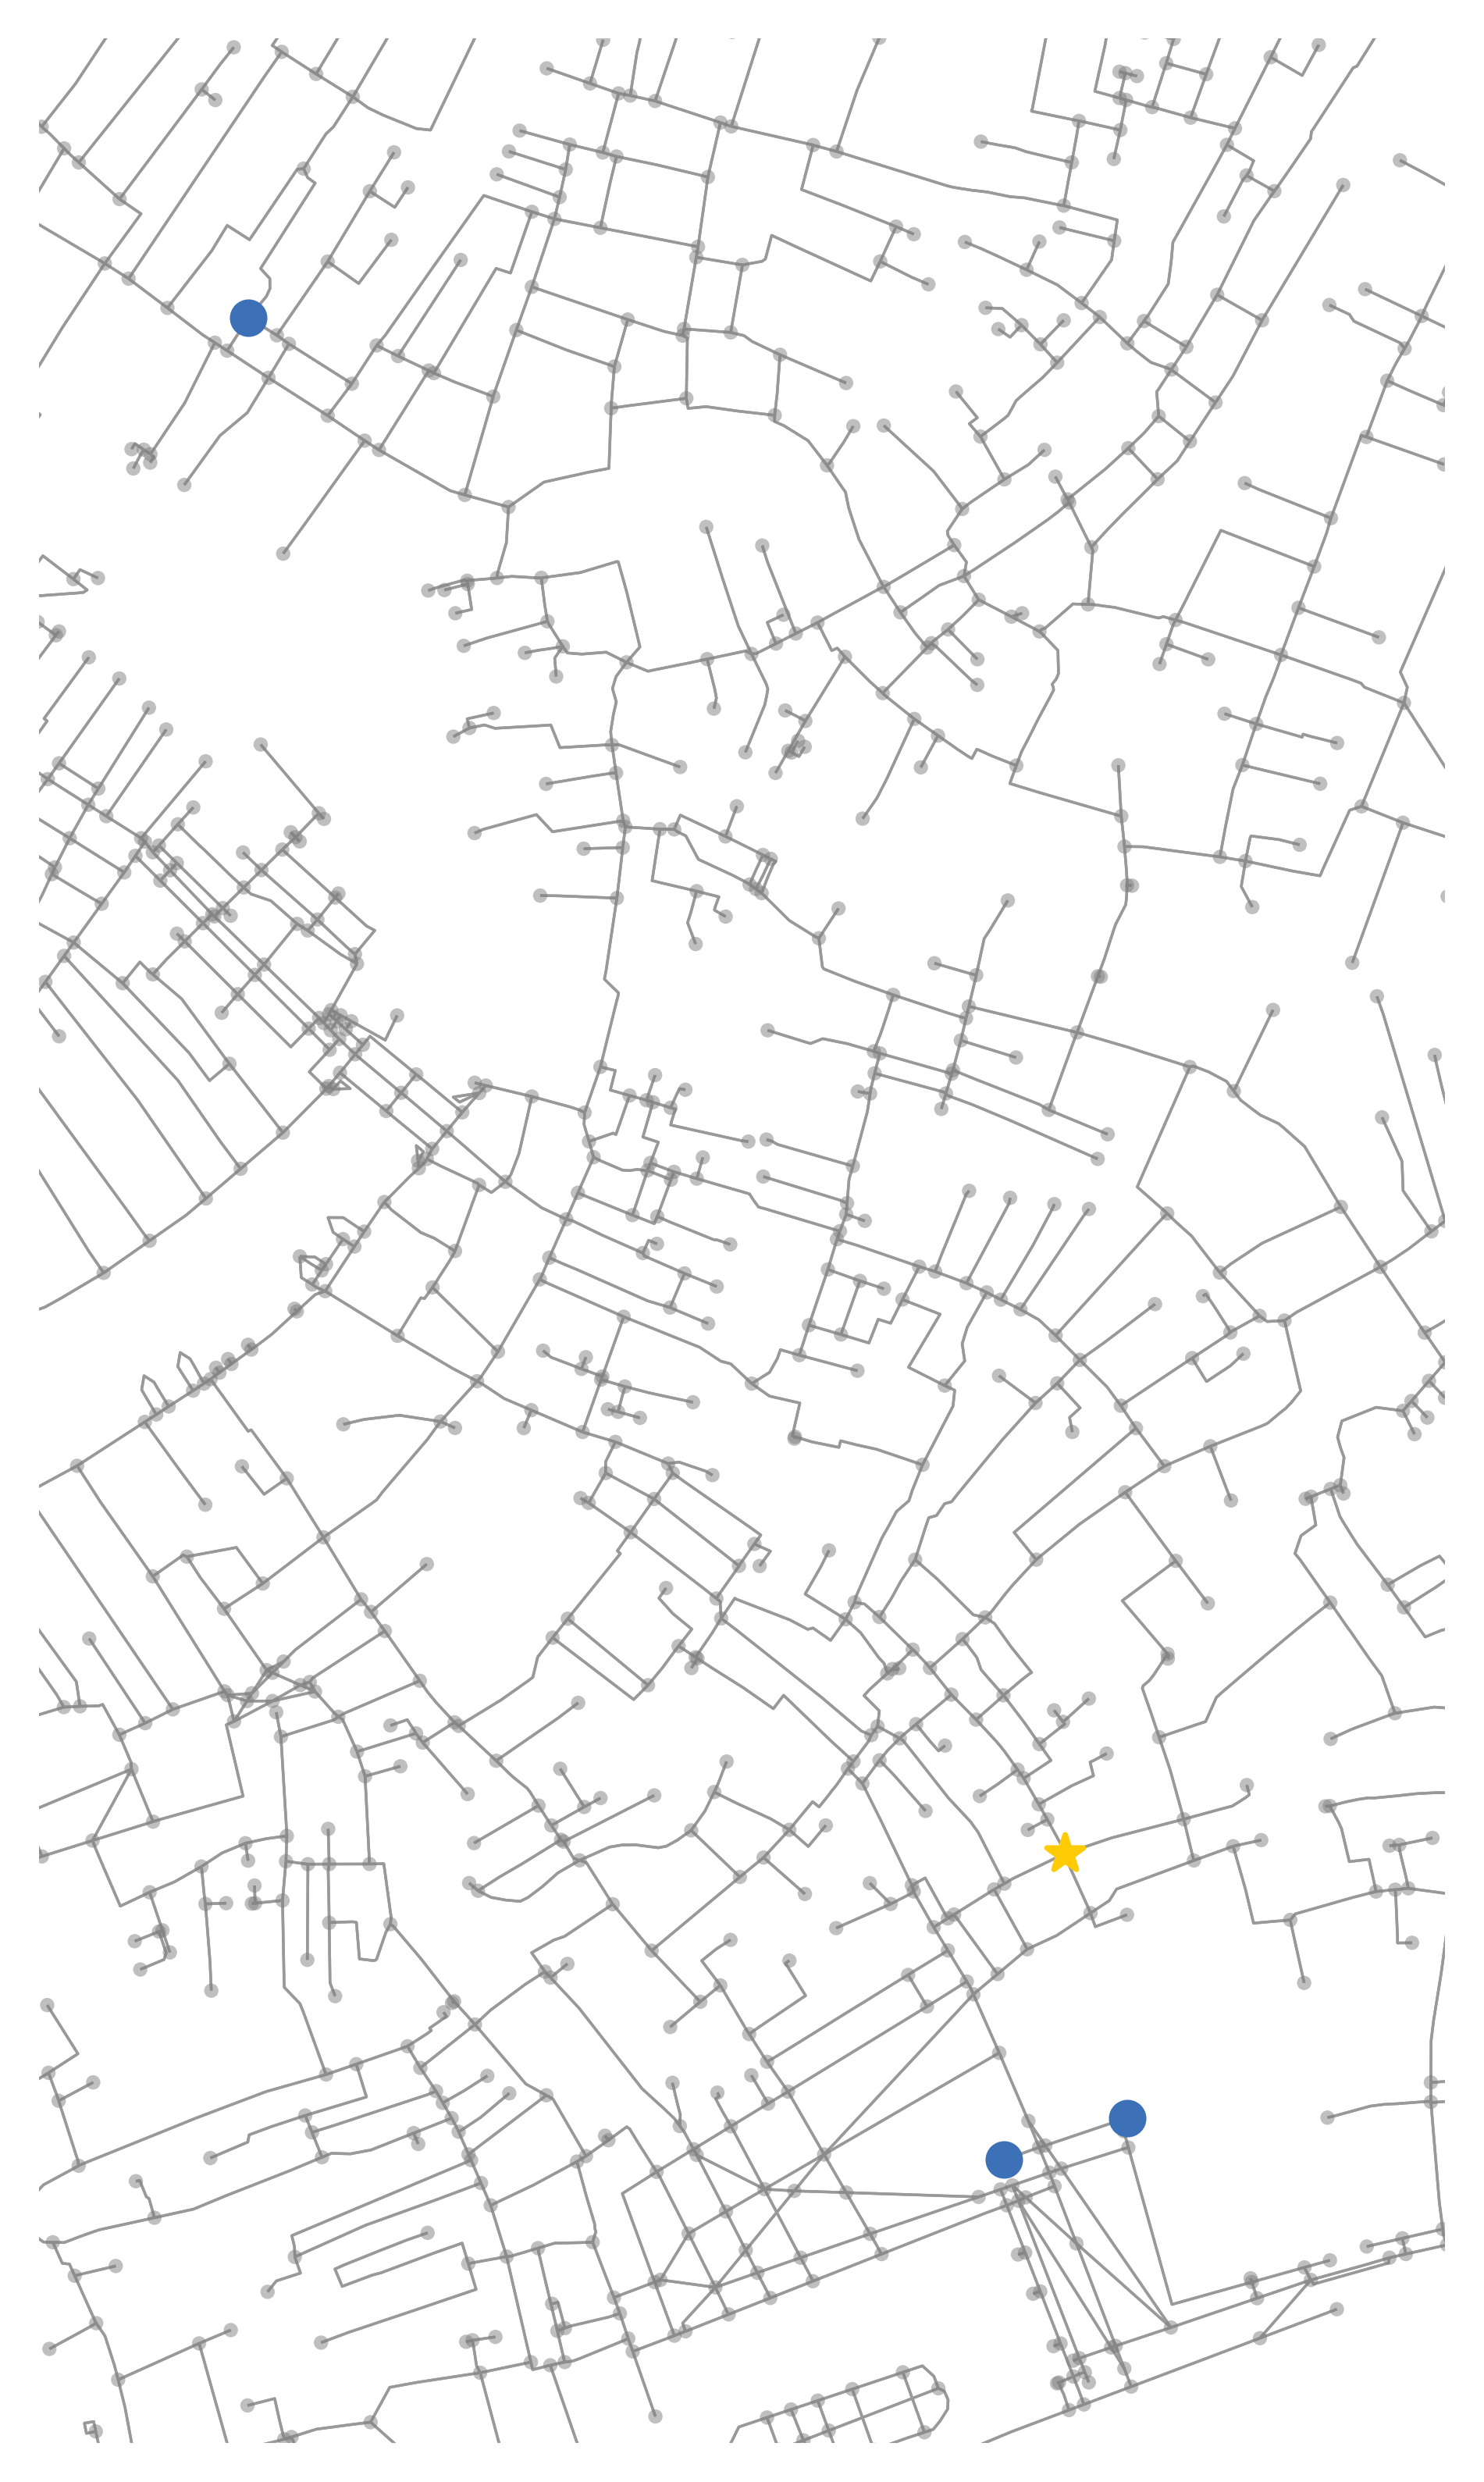

In [103]:
# Plotting for showing shotest path
# original node: 12.339033 45.434036          nearest node: 12.339149 45.434062

G2 = G
trip_times = [X_minutes]  # in minutes

cmap_var = "Wistia"#"Greens" #"Wistia"  #"summer" #
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G2.edges(data=True, keys=True):
    data["time"] = data["length"] / speed_mm
    
# get one color for each isochrone (r, g, b, alpha)
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap=cmap_var, start=1, stop=0, alpha = 1)
# color the nodes according to isochrone then plot the street network
node_colors = {}
node_time = {}

for center_node in hotels_df["id_nearest_node_H"]:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G2, center_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            if node in node_time and trip_time < node_time[node]:
                node_colors[node] = color
                node_time[node] = trip_time
            elif node not in node_time:
                node_colors[node] = color
                node_time[node] = trip_time
nc = ["gray" if node in node_colors else "none" for node in G2.nodes()]
ns = [7 if node in node_colors else 7 for node in G2.nodes()]
mpl.rcParams['figure.dpi'] = 500

cmap = plt.cm.get_cmap(cmap_var)
norm = plt.Normalize(vmin=np.min(trip_times), vmax=np.max(trip_times))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


fig, ax = ox.plot_graph(G2, node_color=nc, node_size=ns, node_alpha=0.5,
                        edge_linewidth=0.5, edge_color="#999999", bgcolor="white", 
                        show=False, close=False)

    
# Adding Hotels, Restaurants, Attractions, and Tram/Metro stations
#ax.scatter(hotels_df["x_nearest_node_H"].values, hotels_df["y_nearest_node_H"].values, 
#           color='green', s=10, zorder=2, marker = 'o', label="Hotels")

# Hotel
ax.scatter(12.339472, 45.435206, 
           color='#ffcb05', s=50, zorder=2, marker = '*')

# Attractions
# Campanile di San Marco
ax.scatter(12.339149, 45.434062, 
           color='#3c71b7', s=35, zorder=2, marker = 'o')
# Basilica di San Marco
ax.scatter(12.339804, 45.434217, 
           color='#3c71b7', s=35, zorder=2, marker = 'o')
#Chiesa Di Santa Sofia
ax.scatter(12.335118, 45.440954, 
           color='#3c71b7', s=35, zorder=2, marker = 'o')



# Set zoom (xlim and ylim to focus on the desired area)
ax.set_xlim(12.3340, 12.3415)
ax.set_ylim(45.4330, 45.4420)



#ax.legend(loc='upper right', fontsize = "x-small", markerscale = 2)

#cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.5)
#cb.ax.tick_params(labelsize=7)
#cb.set_label('Minutes', fontsize = 7)

plt.show()

In [ ]:
import osmnx as ox
import matplotlib as mpl


location_point = (45.3986490196774, 11.874350466689211)

place_name = "Padova, Italy"

mpl.rcParams['figure.dpi'] = 500
# create network from point, inside bounding box of N, S, E, W each 750m from point
#plt.title("Padova: All street network'")
#G_walk = ox.graph_from_point(location_point, dist=dist, dist_type="bbox", network_type="walk", simplify = False)

#Drive network
G_walk = ox.graph_from_point(location_point, dist=300, dist_type="bbox", network_type="walk", simplify = False)
#G_drive = ox.graph_from_place(place_name, network_type="walk", retain_all=True, simplify = False)

fig, ax = ox.plot_graph(G_walk, node_color="white", edge_color="gray", node_edgecolor = "blue",
                        edge_linewidth=1, node_size=1.5, bgcolor="white", 
                        figsize=(6, 6)) 

In [ ]:
plt.style.use('default')
xx = np.linspace(0, 10000, 10000)
zz_avg = 500
yy = xx/(xx + zz_avg)
fig,ax=plt.subplots(1,1)
ax.plot(xx, yy)
ax.plot(xx, (1-yy))
ax.set_ylabel("Weight value")
ax.set_xlabel("Number of reviews")
ax.legend(["POI review score weight", "Average of review scores weight"])
ax.axvline(x=zz_avg, ymax=0.5, linestyle = "--", color="gray")
ax.axhline(y=1, linestyle = "dotted", color="gray")
ax.axhline(y=0, linestyle = "dotted", color="gray")
ax.set_xticks([0, 500, 2000, 4000, 6000, 8000, 10000])

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(xx, yy*4.5 + (1-yy)*3)
ax.plot(xx, yy*3.5 + (1-yy)*3)
ax.axhline(y=4.5, linestyle = "dotted", color="#1f77b4") 
ax.axhline(y=3.5, linestyle = "dotted", color="#ff7f0e")
ax.set_yticks(np.arange(3, 5, 0.5))
ax.set_ylim([3, 4.6])
ax.set_xticks([0, 2000, 4000, 6000, 8000, 10000])
ax.set_ylabel("Bayesian average value")
ax.set_xlabel("Number of reviews")
ax.legend(["POI with review score 4.5", "POI with review score 3.5"])

In [117]:
df.Walkability.value_counts()

Walkability
Average     102
High         73
Basic        64
Excelent     58
Poor         15
Name: count, dtype: int64

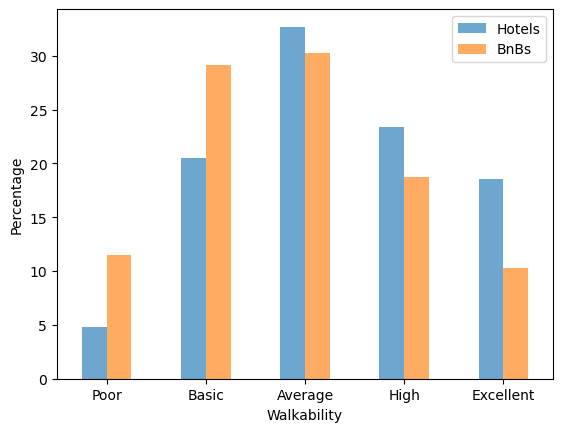

In [118]:
# Sample data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

walkability_levels = ['Poor', 'Basic', 'Average', 'High', 'Excellent']
counts_for_plot_hotels_1 = [15, 64, 102, 73, 58]
counts_for_plot_airbnb_1 = [557, 1414, 1468, 911, 501]

counts_for_plot_hotels = [x * 100 / np.sum(counts_for_plot_hotels_1) for x in counts_for_plot_hotels_1]
counts_for_plot_airbnb = [x * 100 / np.sum(counts_for_plot_airbnb_1) for x in counts_for_plot_airbnb_1]

# Create DataFrame
df = pd.DataFrame({
    "Walkability": walkability_levels,
    "Counts_hotels": counts_for_plot_hotels,
    "Counts_airbnb": counts_for_plot_airbnb
})

# Plot the DataFrame
ax = df.plot.bar(x="Walkability", y=["Counts_hotels", "Counts_airbnb"], 
                 color=["#1f77b4", "#ff7f0e"], alpha=0.65, 
                 xlabel="Walkability", ylabel="Count", rot=0)

# Add labels and title
plt.xlabel("Walkability")
plt.ylabel("Percentage")
#plt.title("Comparison of Counts by Walkability Levels")
plt.legend(["Hotels", "BnBs"])

# Show plot
plt.show()